# Обучение модели на начальных данных

## Импорты

In [29]:
import os
import json
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from ultralytics import YOLO
import yaml
from pathlib import Path
from tabulate import tabulate
from IPython import display

## Маппинг категорий для YOLO

In [2]:
categories = [
    "Предупреждающие",
    "Знаки приоритета",
    "Запрещающие",
    "Предписывающие",
    "Особые предписания",
    "Информационные",
    "Сервисные",
    "С доп. информацией"
]

# Создаем словарь для конвертации имени в ID
name_to_id = {name: idx for idx, name in enumerate(categories)}  # YOLO использует 0-7

print("Маппинг категорий:")
for name, id in name_to_id.items():
    print(f"{name} -> {id}")

Маппинг категорий:
Предупреждающие -> 0
Знаки приоритета -> 1
Запрещающие -> 2
Предписывающие -> 3
Особые предписания -> 4
Информационные -> 5
Сервисные -> 6
С доп. информацией -> 7


## Конвертируем COCO в YOLO

In [3]:
root = 'archive'
image_dir = os.path.join(root, 'rtsd-frames/rtsd-frames')
train_json = os.path.join(root, 'train_anno_with_categories.json')
val_json = os.path.join(root, 'val_anno_with_categories.json')

output_root = 'rtsd_yolo_without_aug'
train_out = os.path.join(output_root, 'train')
val_out = os.path.join(output_root, 'val')

os.makedirs(train_out, exist_ok=True)
os.makedirs(val_out, exist_ok=True)

In [4]:
def convert_coco_to_yolo(coco_json, output_dir, image_dir):
    os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels'), exist_ok=True)

    with open(coco_json) as f:
        data = json.load(f)

    images_info = {img['id']: img for img in data['images']}

    for ann in tqdm(data['annotations']):
        img = images_info[ann['image_id']]
        fname = img['file_name'].split('/')[-1]
        image_path = os.path.join(image_dir, fname)

        if not os.path.exists(image_path):
            print(f"Missing image: {image_path}")
            continue

        try:
            class_id = name_to_id[ann['category_name']]
        except KeyError:
            print(f"Unknown category: {ann['category_name']}")
            continue
        
        width, height = img['width'], img['height']
        x, y, w, h = ann['bbox']
        x_center = (x + w / 2) / width
        y_center = (y + h / 2) / height
        bbox_w = w / width
        bbox_h = h / height

        yolo_ann = f"{class_id} {x_center} {y_center} {bbox_w} {bbox_h}\n"
        label_path = os.path.join(output_dir, 'labels', fname.replace('.jpg', '.txt'))

        with open(label_path, 'a') as f:
            f.write(yolo_ann)

        shutil.copy(image_path, os.path.join(output_dir, 'images', fname))

In [5]:
convert_coco_to_yolo(train_json, train_out, image_dir)
convert_coco_to_yolo(val_json, val_out, image_dir)

100%|██████████| 8866/8866 [00:30<00:00, 292.06it/s]


## Создание data.yaml для YOLO

In [6]:
# Пути относительно расположения data.yaml
data = {
    'path': str(Path('rtsd_yolo_without_aug').absolute()),  # корневая папка датасета
    'train': 'train/images',  # относительно 'path'
    'val': 'val/images',
    'names': {
        0: 'Предупреждающие',
        1: 'Знаки приоритета',
        2: 'Запрещающие',
        3: 'Предписывающие',
        4: 'Особые предписания',
        5: 'Информационные',
        6: 'Сервисные',
        7: 'С доп. информацией'
    }
}

# Сохранение файла
with open('data.yaml', 'w', encoding='utf-8') as f:
    yaml.dump(data, f, allow_unicode=True, sort_keys=False)

print("Файл data.yaml создан. Содержимое:")
print(yaml.dump(data, allow_unicode=True, sort_keys=False))

Файл data.yaml создан. Содержимое:
path: c:\Innopolis\Zala_Project\rtsd_yolo_without_aug
train: train/images
val: val/images
names:
  0: Предупреждающие
  1: Знаки приоритета
  2: Запрещающие
  3: Предписывающие
  4: Особые предписания
  5: Информационные
  6: Сервисные
  7: С доп. информацией



## Обучение моделей

**Обучим модель на начальных имеющихся данных.**

### Обучение YOLO11s без аугментации

In [8]:
# Инициализация модели
model_11s = YOLO('yolo11s.pt')
# Параметры обучения
results = model_11s.train(
    data='data.yaml',
    epochs=10,  
    patience=2,  # Остановка при отсутствии улучшений
    batch=16,  
    imgsz=640,  # Не уменьшать для дорожных знаков
    device=0,  # Использовать GPU
    workers=2,  # Потоки загрузки данных
    optimizer='AdamW',  # Лучше для transfer learning
    lr0=0.001,  # Learning rate
    lrf=0.01,  # Final LR = lr0 * lrf
    weight_decay=0.0005,
    amp=True,  # Mixed Precision (ускорение + экономия памяти)
    cache=True,  # Кеширование (требует RAM)
    single_cls=False,  # У нас 8 классов
    pretrained=True,  # Использовать предобученные веса
    plots=True,  # Генерация графиков
    project='RTSD_YOLO11s_without_aug',
    name='yolo11s_without_aug',
    augment=False
)

New https://pypi.org/project/ultralytics/8.3.141 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.112  Python-3.12.8 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolo11s.pt, data=data.yaml, epochs=10, time=None, patience=2, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=0, workers=2, project=RTSD_YOLO11s_without_aug, name=yolo11s_without_aug, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=Fa

train: Scanning C:\Innopolis\Zala_Project\rtsd_yolo_without_aug\train\labels... 54188 images, 0 backgrounds, 0 corrupt: 100%|██████████| 54188/54188 [00:25<00:00, 2141.51it/s]


train: New cache created: C:\Innopolis\Zala_Project\rtsd_yolo_without_aug\train\labels.cache
WARNING train: 52.3GB RAM required to cache images with 50% safety margin but only 3.5/15.9GB available, not caching images
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.20.1 ms, read: 42.619.3 MB/s, size: 155.3 KB)


val: Scanning C:\Innopolis\Zala_Project\rtsd_yolo_without_aug\val\labels... 5000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:02<00:00, 2077.04it/s]


val: New cache created: C:\Innopolis\Zala_Project\rtsd_yolo_without_aug\val\labels.cache
WARNING val: 4.8GB RAM required to cache images with 50% safety margin but only 2.2/15.9GB available, not caching images
Plotting labels to RTSD_YOLO11s_without_aug\yolo11s_without_aug\labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to RTSD_YOLO11s_without_aug\yolo11s_without_aug
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      3.92G      1.209      1.043     0.8842         23        640: 100%|██████████| 3387/3387 [13:42<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:30<00:00,  5.18it/s]


                   all       5000       8866       0.77      0.689      0.769       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.99G      1.145     0.7961     0.8705         21        640: 100%|██████████| 3387/3387 [12:34<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:30<00:00,  5.11it/s]

                   all       5000       8866      0.787      0.757      0.812      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         4G      1.098      0.722     0.8625         23        640: 100%|██████████| 3387/3387 [12:54<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:29<00:00,  5.38it/s]

                   all       5000       8866      0.839      0.765      0.838      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      3.98G      1.051     0.6654     0.8529         27        640: 100%|██████████| 3387/3387 [12:21<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:28<00:00,  5.46it/s]

                   all       5000       8866      0.849      0.807      0.871      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.98G      1.023     0.6225     0.8476         17        640: 100%|██████████| 3387/3387 [12:23<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:28<00:00,  5.49it/s]

                   all       5000       8866      0.863      0.812      0.882      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      3.96G     0.9959     0.5899     0.8427         19        640: 100%|██████████| 3387/3387 [12:17<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:28<00:00,  5.43it/s]

                   all       5000       8866      0.867      0.838      0.896      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      3.98G     0.9691     0.5601     0.8394         17        640: 100%|██████████| 3387/3387 [12:23<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:29<00:00,  5.36it/s]

                   all       5000       8866      0.869      0.854      0.902      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      3.98G     0.9487     0.5342      0.836         17        640: 100%|██████████| 3387/3387 [12:22<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:28<00:00,  5.45it/s]

                   all       5000       8866      0.875      0.861      0.912      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.99G     0.9243     0.5084     0.8335         16        640: 100%|██████████| 3387/3387 [12:21<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:29<00:00,  5.40it/s]

                   all       5000       8866      0.883      0.862      0.916      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.98G     0.9075     0.4879     0.8298         19        640: 100%|██████████| 3387/3387 [12:22<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:28<00:00,  5.45it/s]

                   all       5000       8866       0.88      0.872       0.92      0.679



10 epochs completed in 2.183 hours.
Optimizer stripped from RTSD_YOLO11s_without_aug\yolo11s_without_aug\weights\last.pt, 19.2MB
Optimizer stripped from RTSD_YOLO11s_without_aug\yolo11s_without_aug\weights\best.pt, 19.2MB

Validating RTSD_YOLO11s_without_aug\yolo11s_without_aug\weights\best.pt...
Ultralytics 8.3.112  Python-3.12.8 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLO11s summary (fused): 100 layers, 9,415,896 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:31<00:00,  4.99it/s]


                   all       5000       8866       0.88      0.872       0.92      0.679
               744        832      0.901      0.928      0.964      0.708
              1469       1542      0.935      0.928      0.971      0.742
                  1035       1136      0.908      0.911      0.955      0.701
                580        660      0.906      0.903      0.956      0.703
            2383       3913      0.886      0.932      0.962      0.713
                313        320      0.864      0.803      0.885      0.626
                     186        198       0.95      0.909      0.951      0.737
     .         245        265      0.687      0.663      0.716        0.5
Speed: 0.2ms preprocess, 2.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to RTSD_YOLO11s_without_aug\yolo11s_without_aug


In [9]:
# Загрузка лучшей модели
best_model_11s_without_aug = YOLO('RTSD_YOLO11s_without_aug/yolo11s_without_aug/weights/best.pt')

**В результате обучения создается папка с сохраненными весами, логами, параметрами обучения и графиками.**

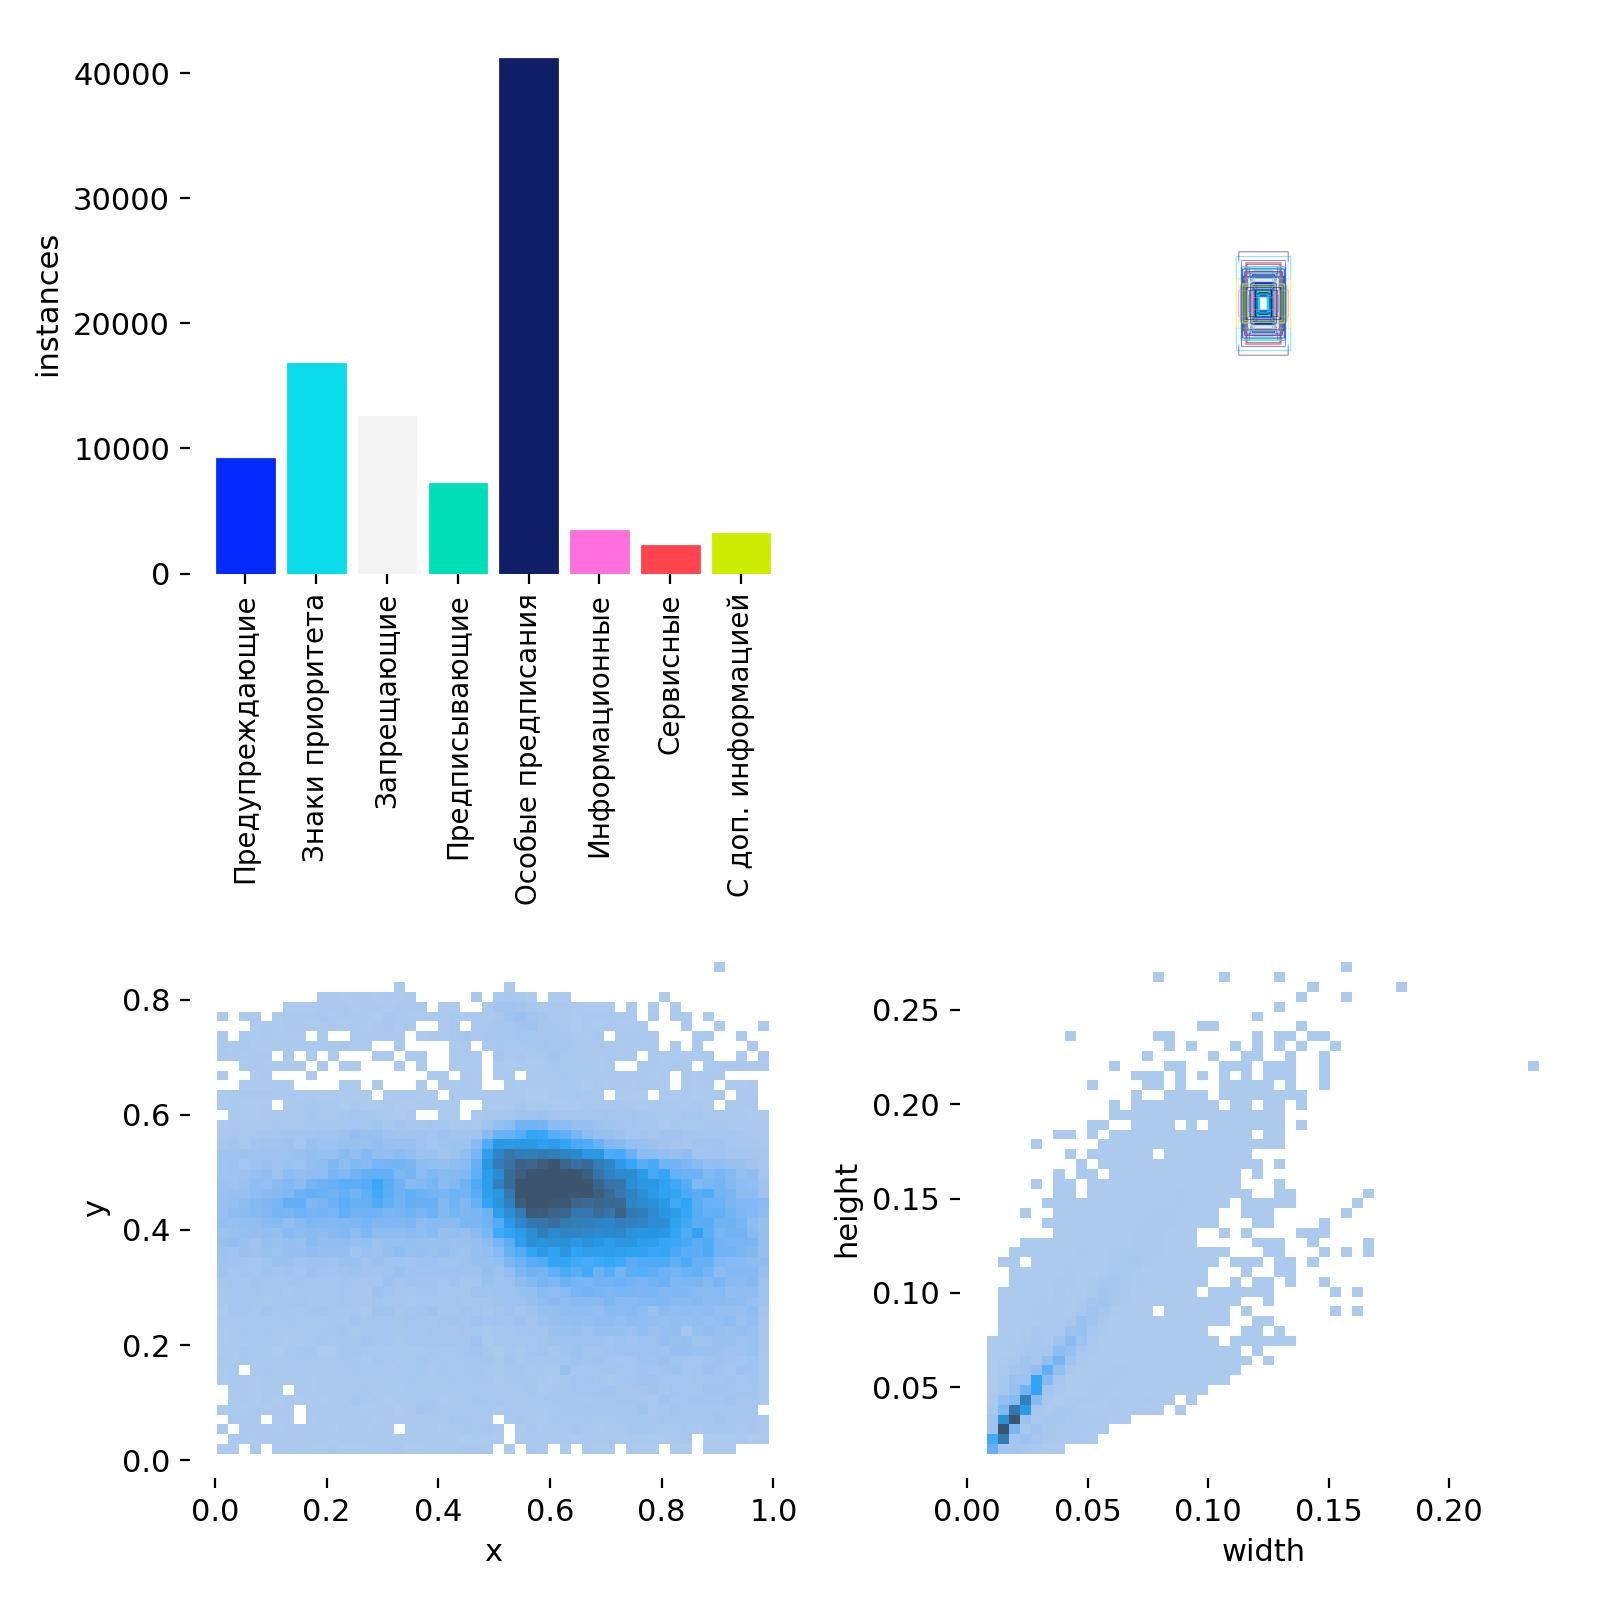

In [23]:
display.Image('RTSD_YOLO11s_without_aug/yolo11s_without_aug/labels.jpg', width=900, height=600)

**Матрица ошибок (confusion matrix) между предсказанными и реальными классами.**

По оси Х — истинные классы (True)

По оси Y — предсказанные (Predicted)

Ячейки: сколько раз модель предсказала Y при наличии X

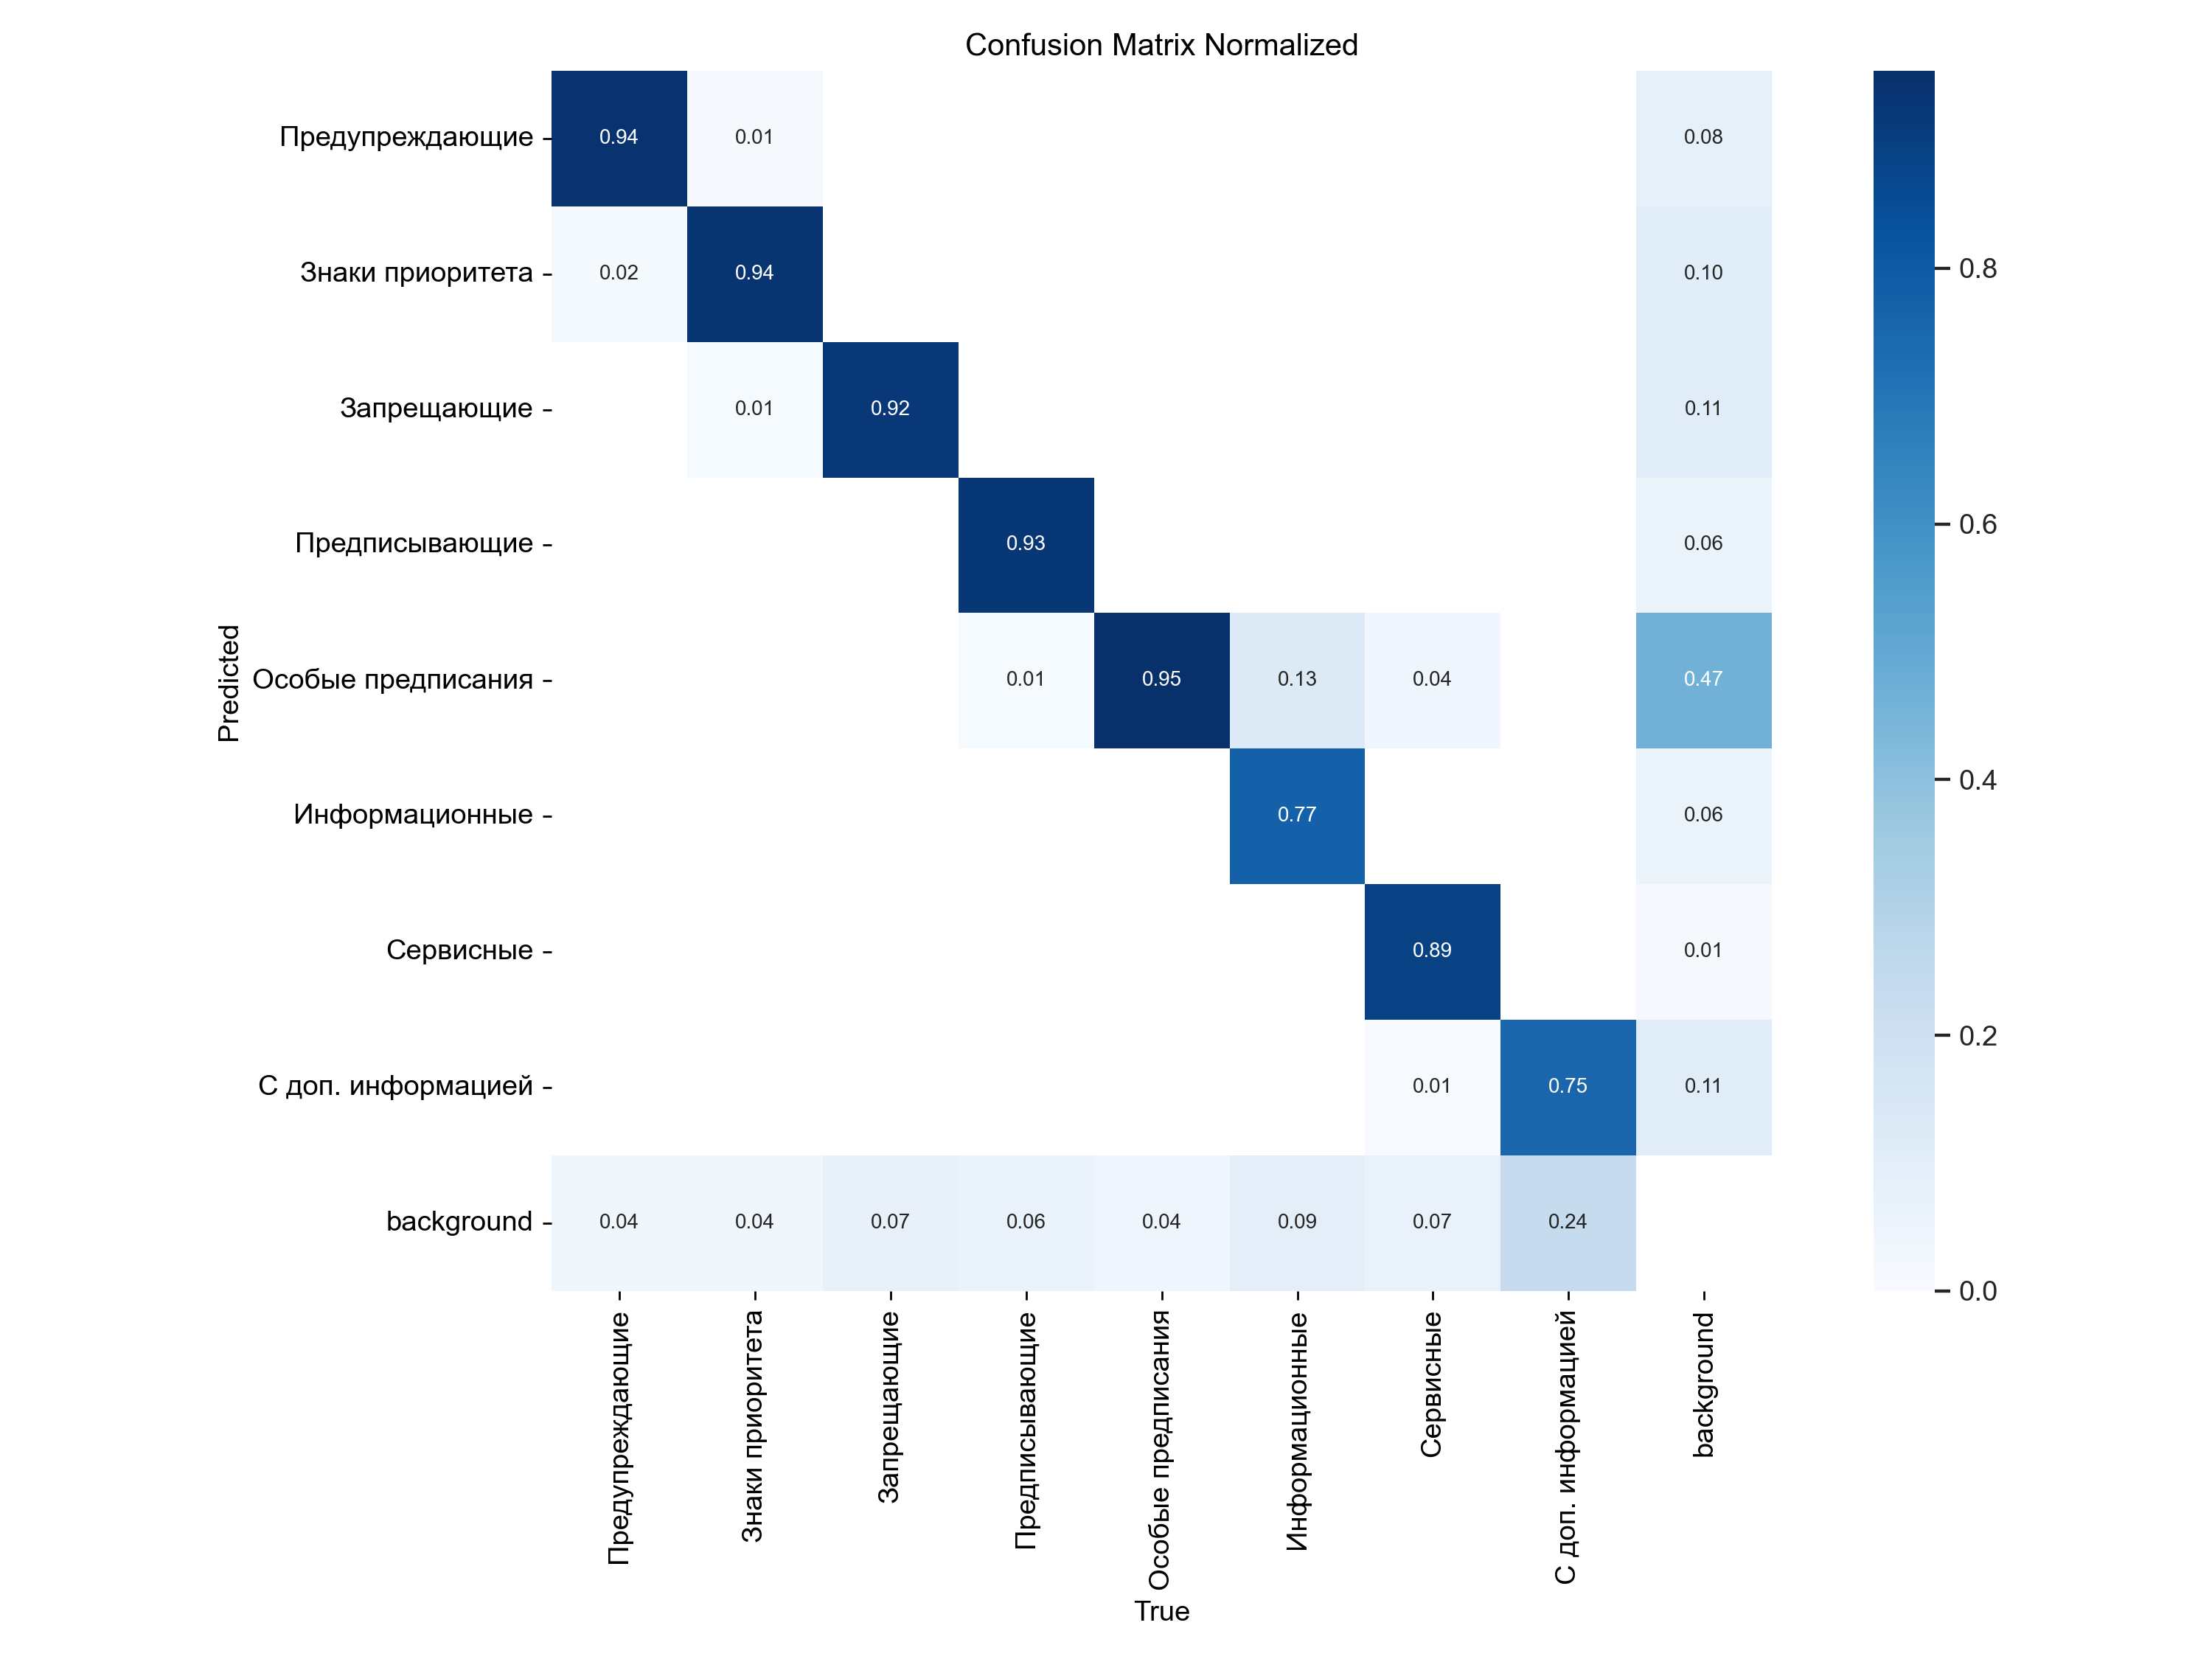

In [18]:
display.Image('RTSD_YOLO11s_without_aug/yolo11s_without_aug/confusion_matrix_normalized.png', width=1200, height=900)

**PR-кривая (Precision vs Recall) — важная кривая для каждой категории:**

Каждая линия — это отдельный класс.

Чем выше и правее линия, тем лучше модель: высокая точность при высокой полноте.

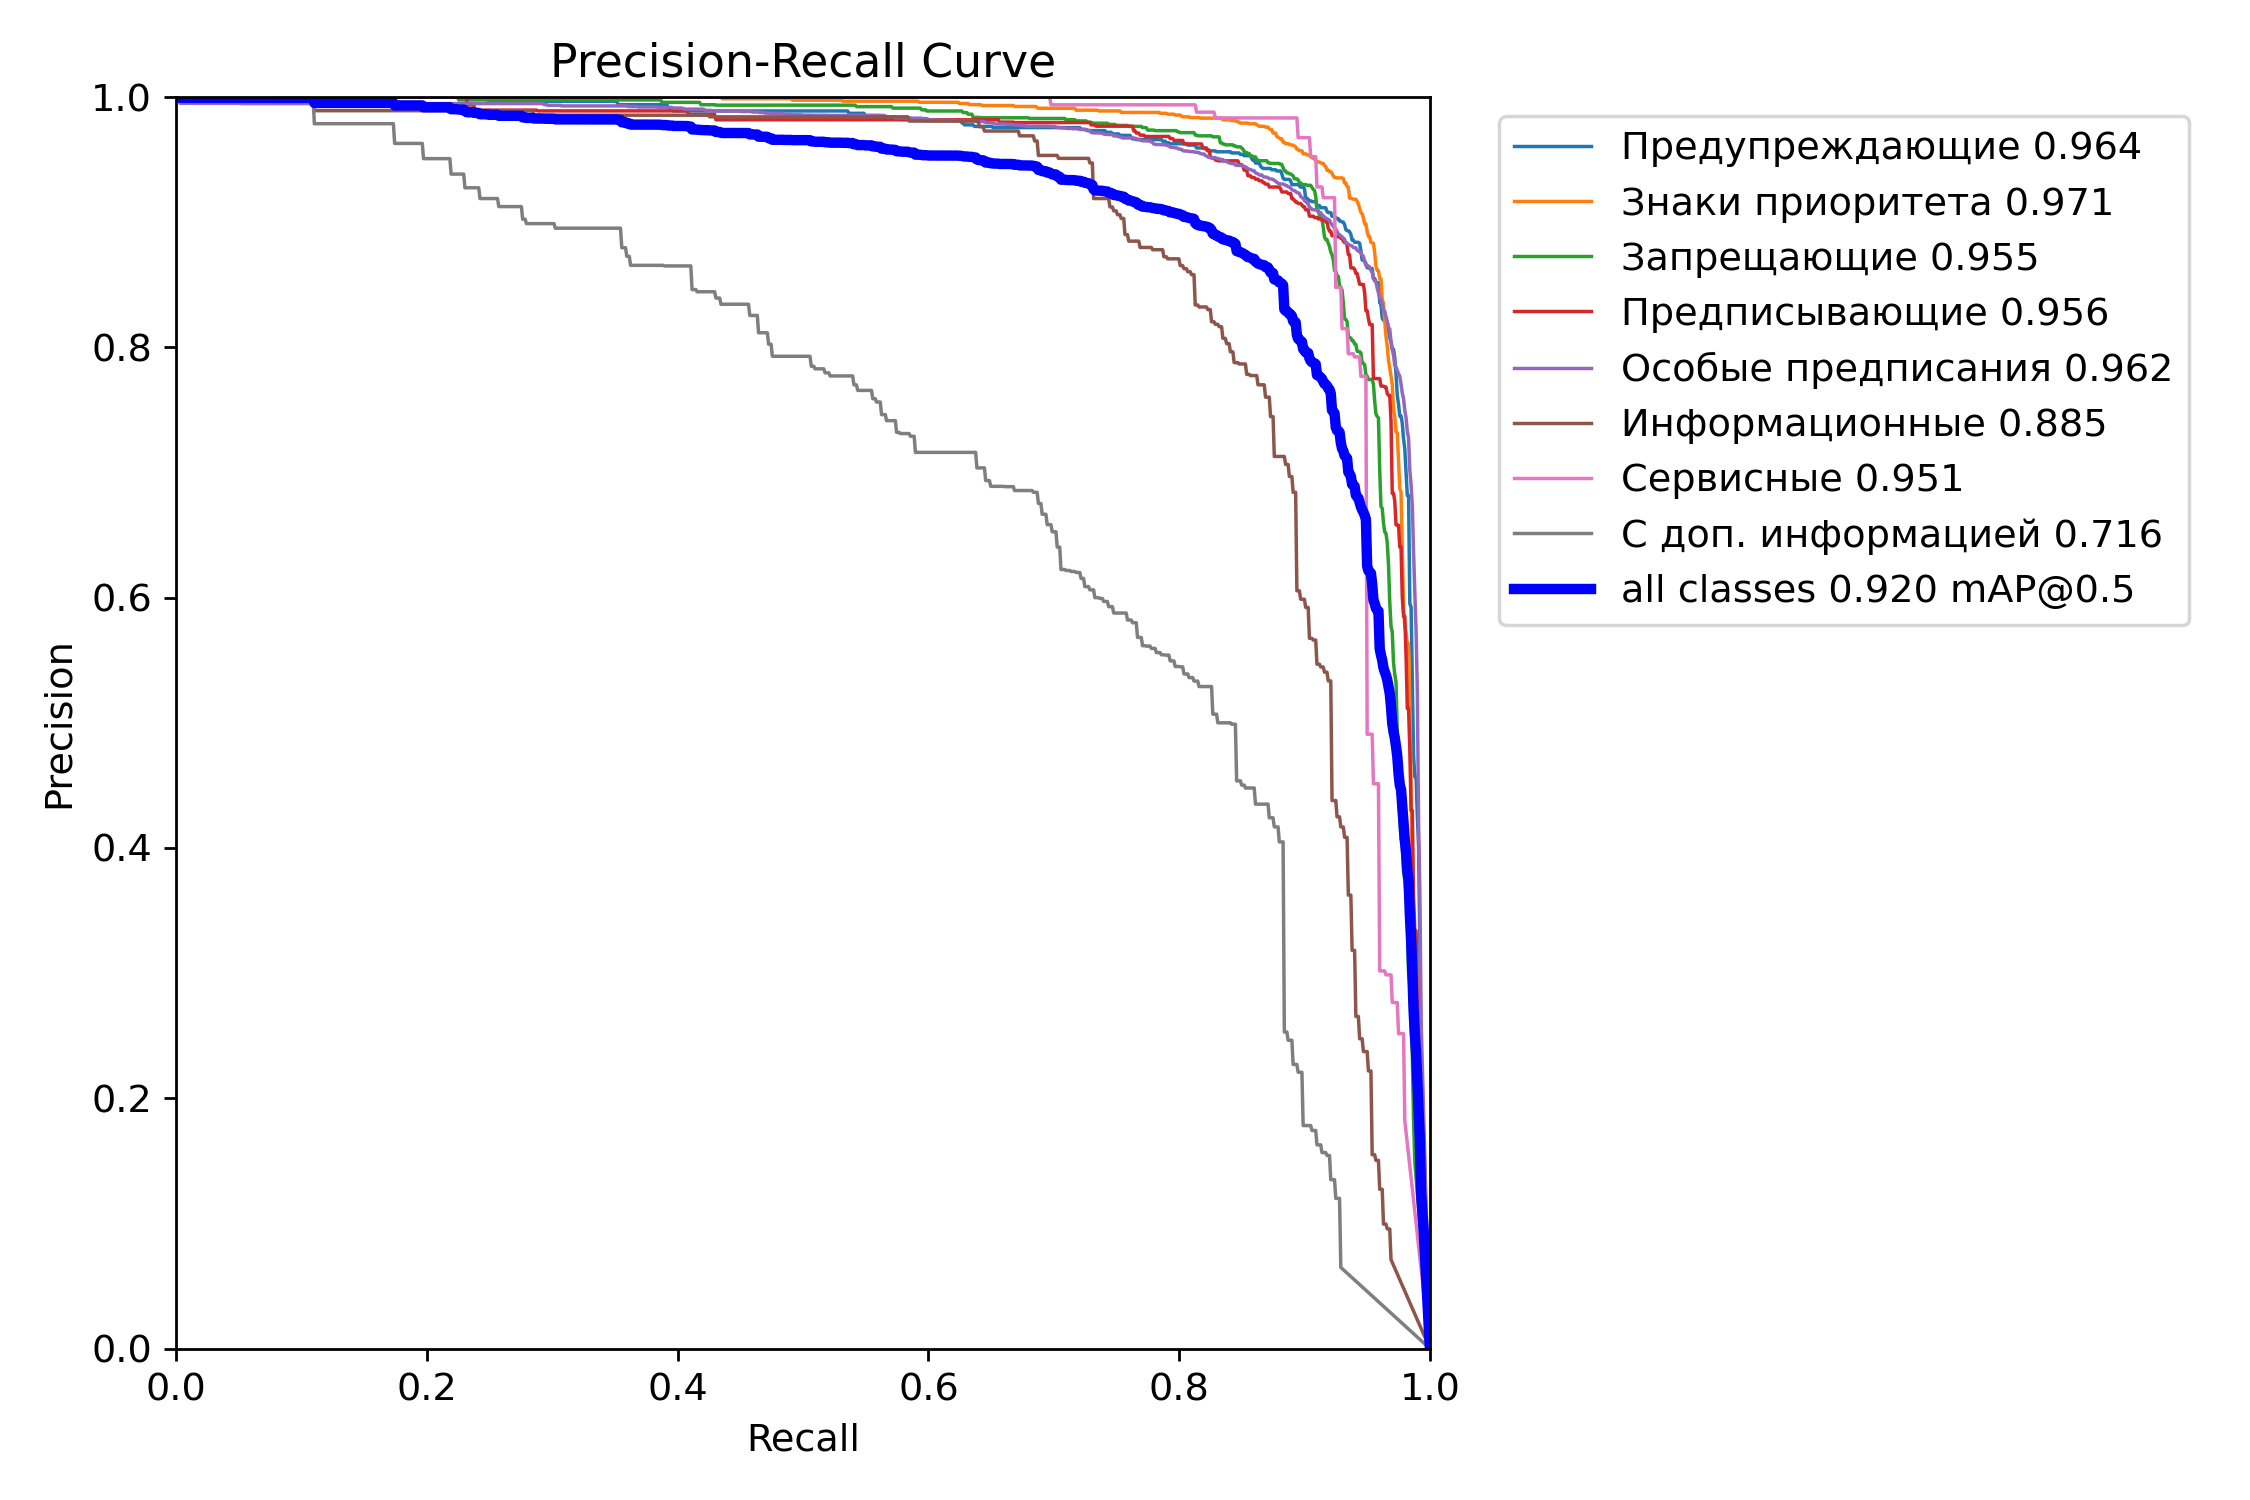

In [9]:
display.Image('RTSD_YOLO11s_without_aug/yolo11s_without_aug/PR_curve.png', width=900, height=600)

**Precision по каждому классу**

Показывает точность модели для каждого класса.

Высокая точность = меньше false positives.

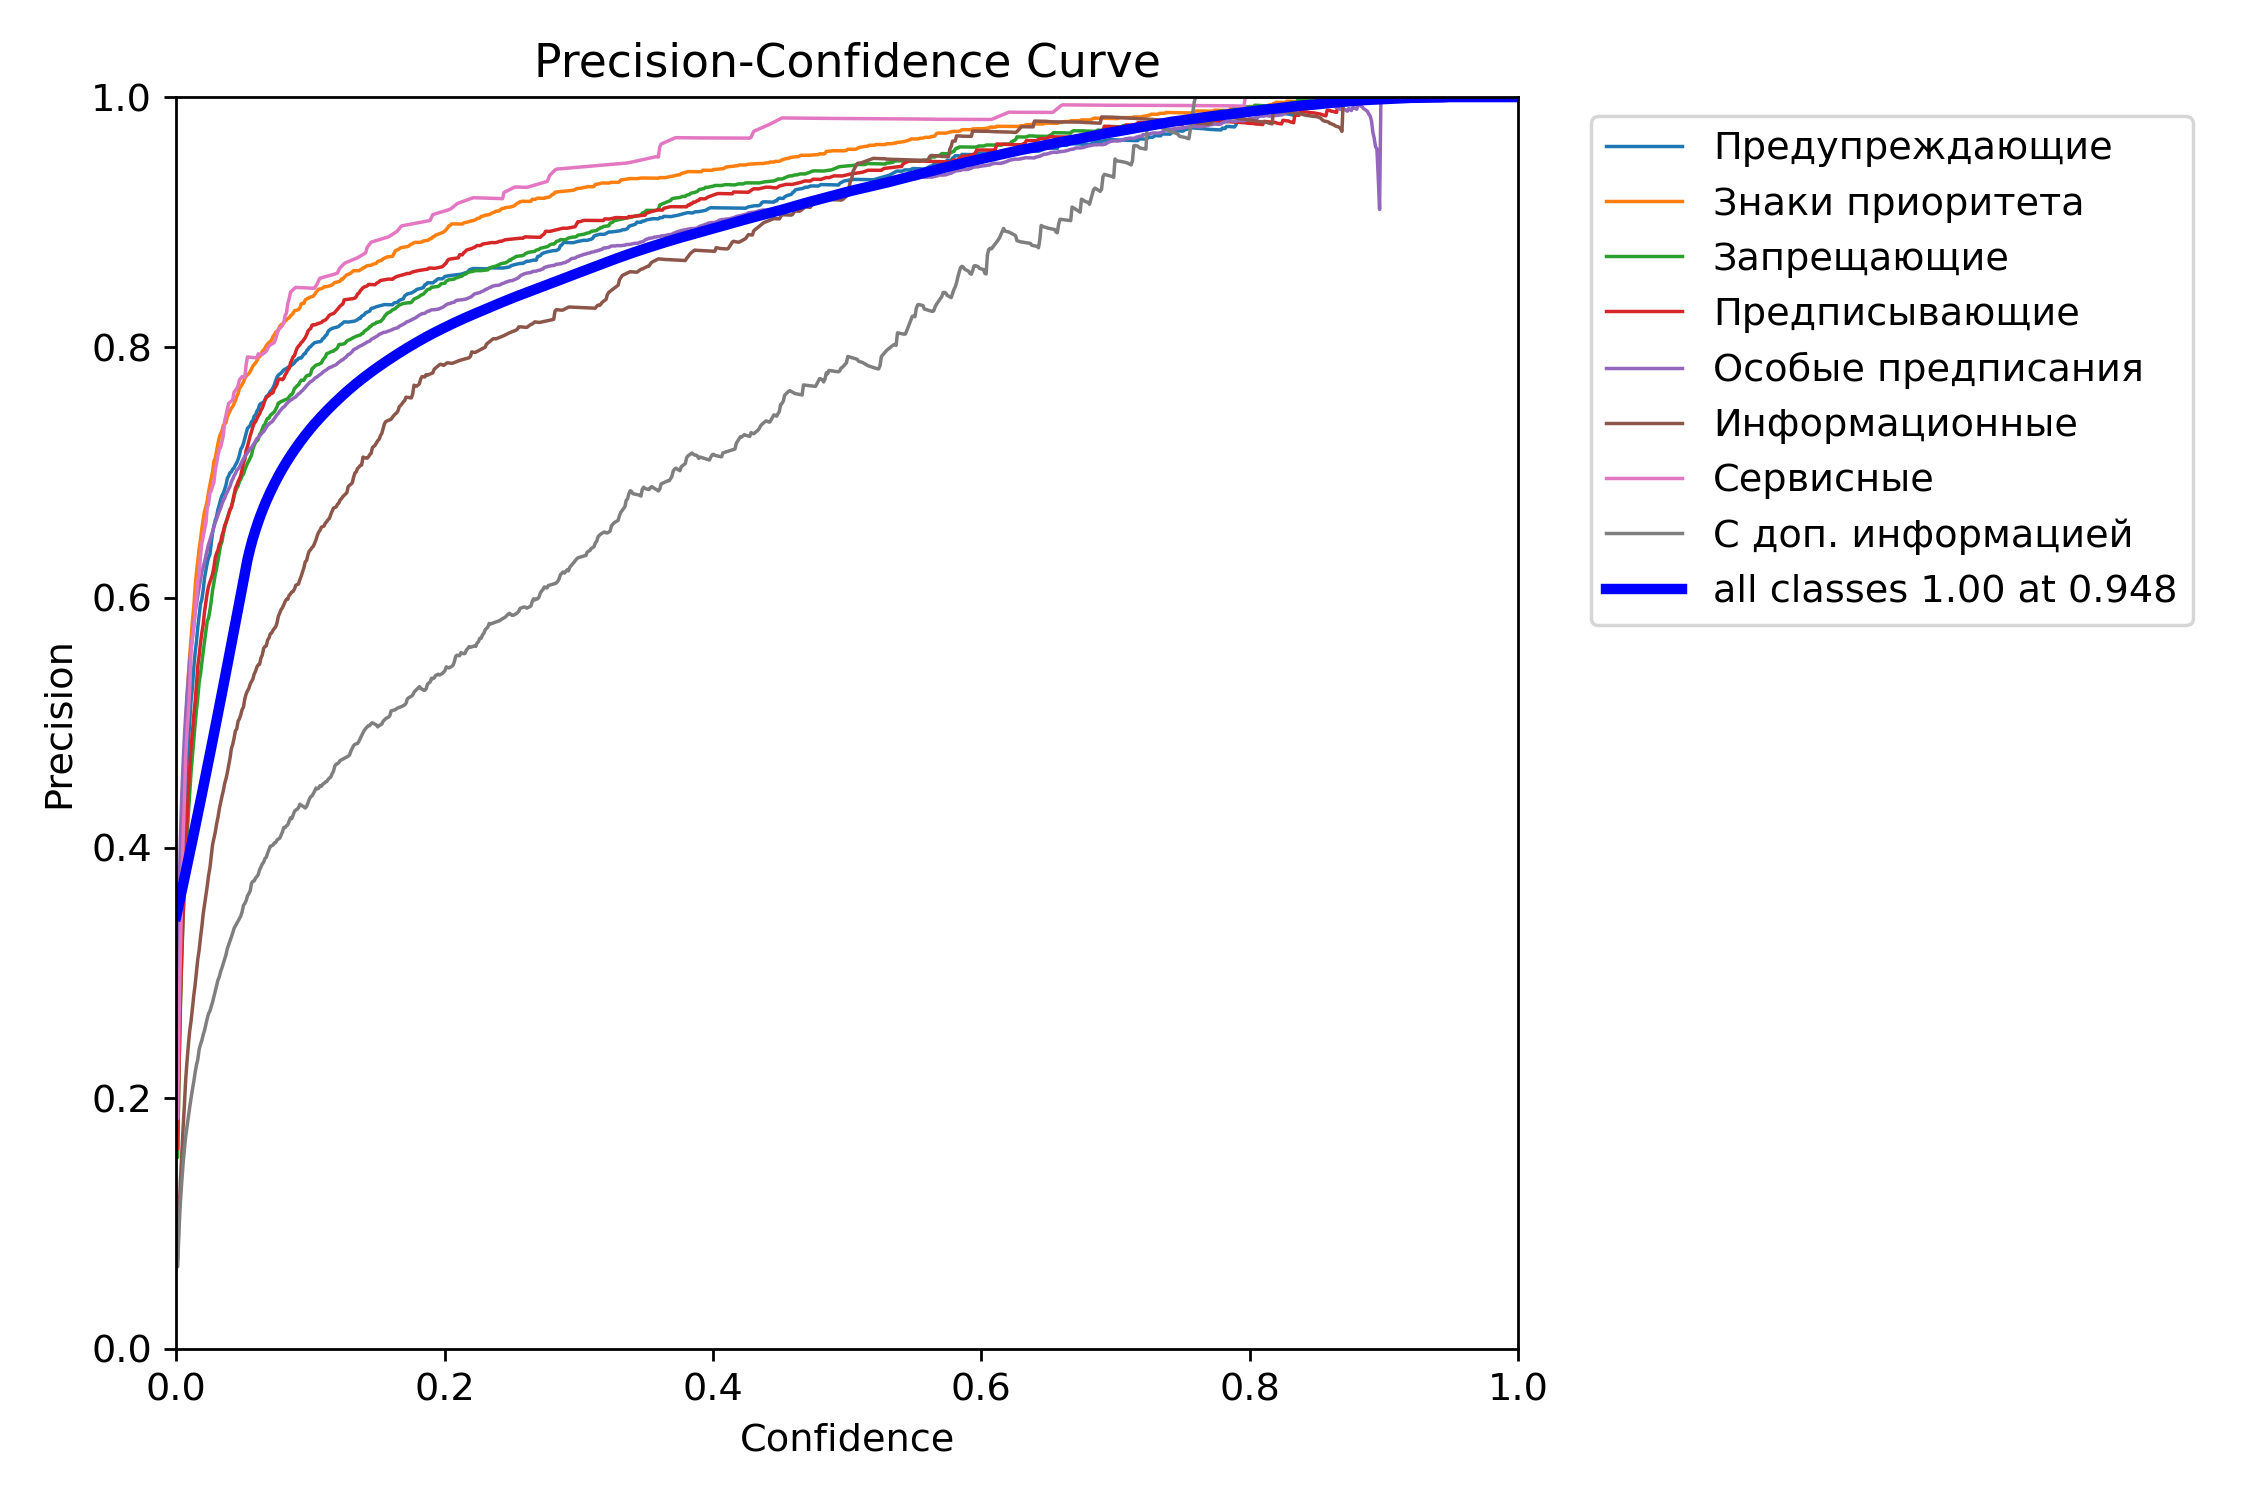

In [10]:
display.Image('RTSD_YOLO11s_without_aug/yolo11s_without_aug/P_curve.png', width=900, height=600)

**F1-метрика по классам**

Гармоническое среднее между точностью и полнотой.

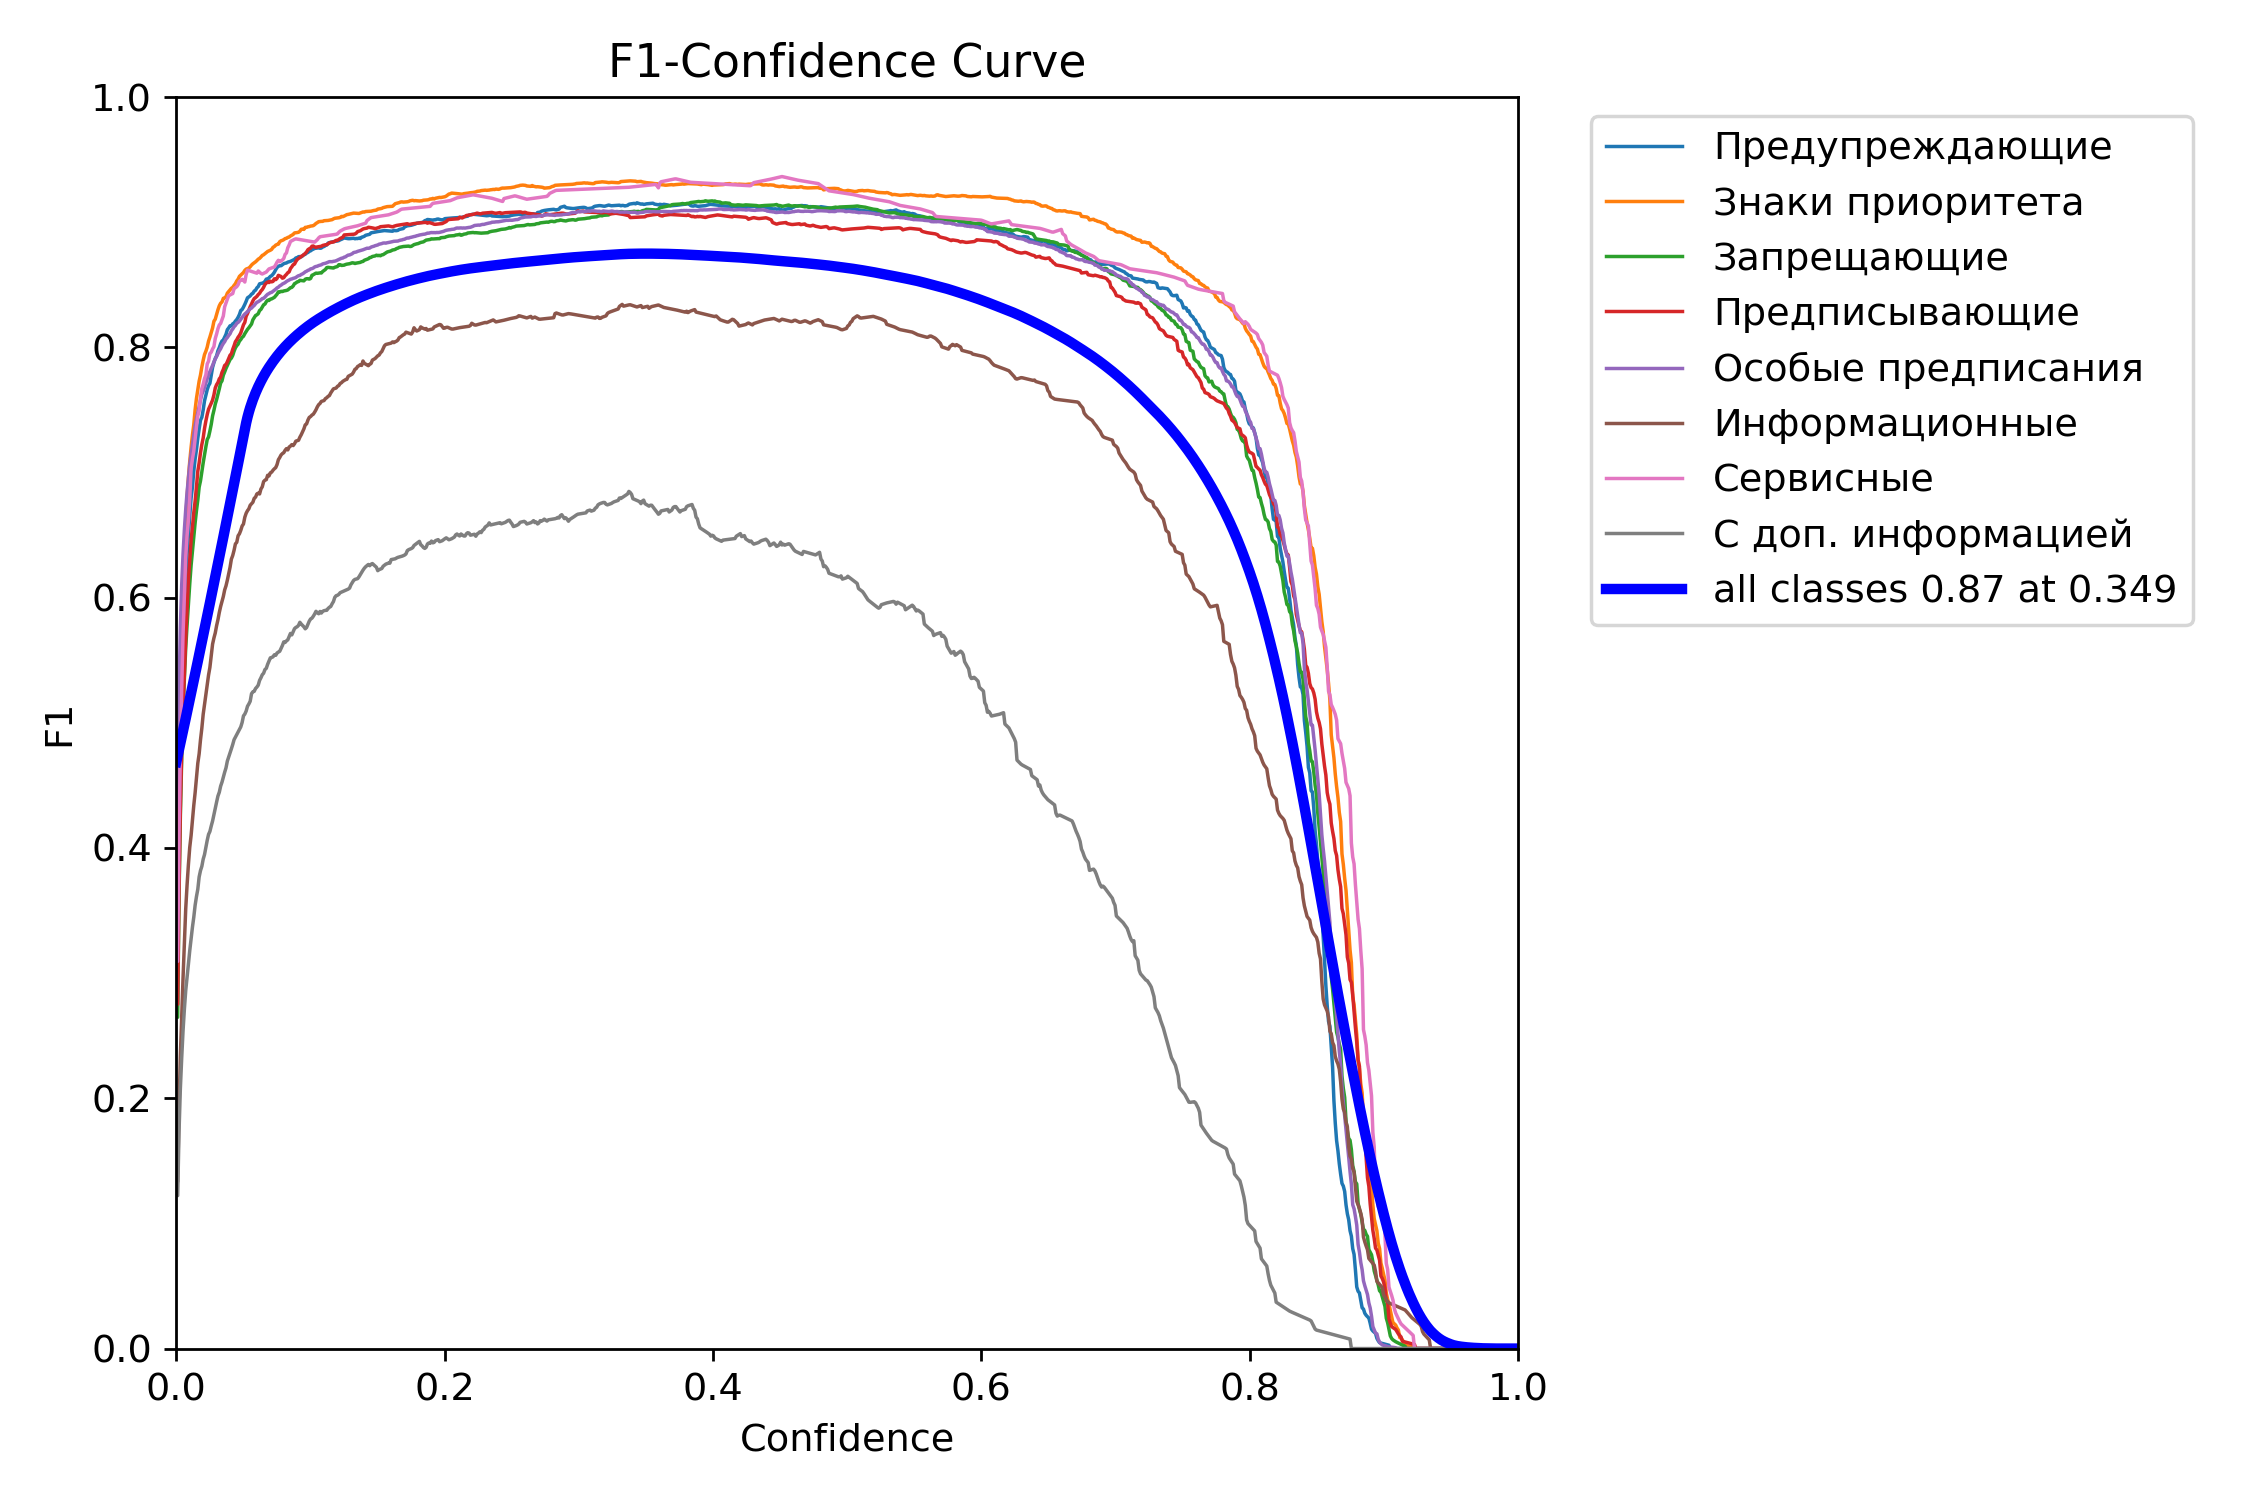

In [21]:
display.Image('RTSD_YOLO11s_without_aug/yolo11s_without_aug/F1_curve.png', width=900, height=600)

**Recall по каждому классу**

Показывает полноту: сколько объектов данного класса удалось найти.

Низкий recall → пропущенные знаки.

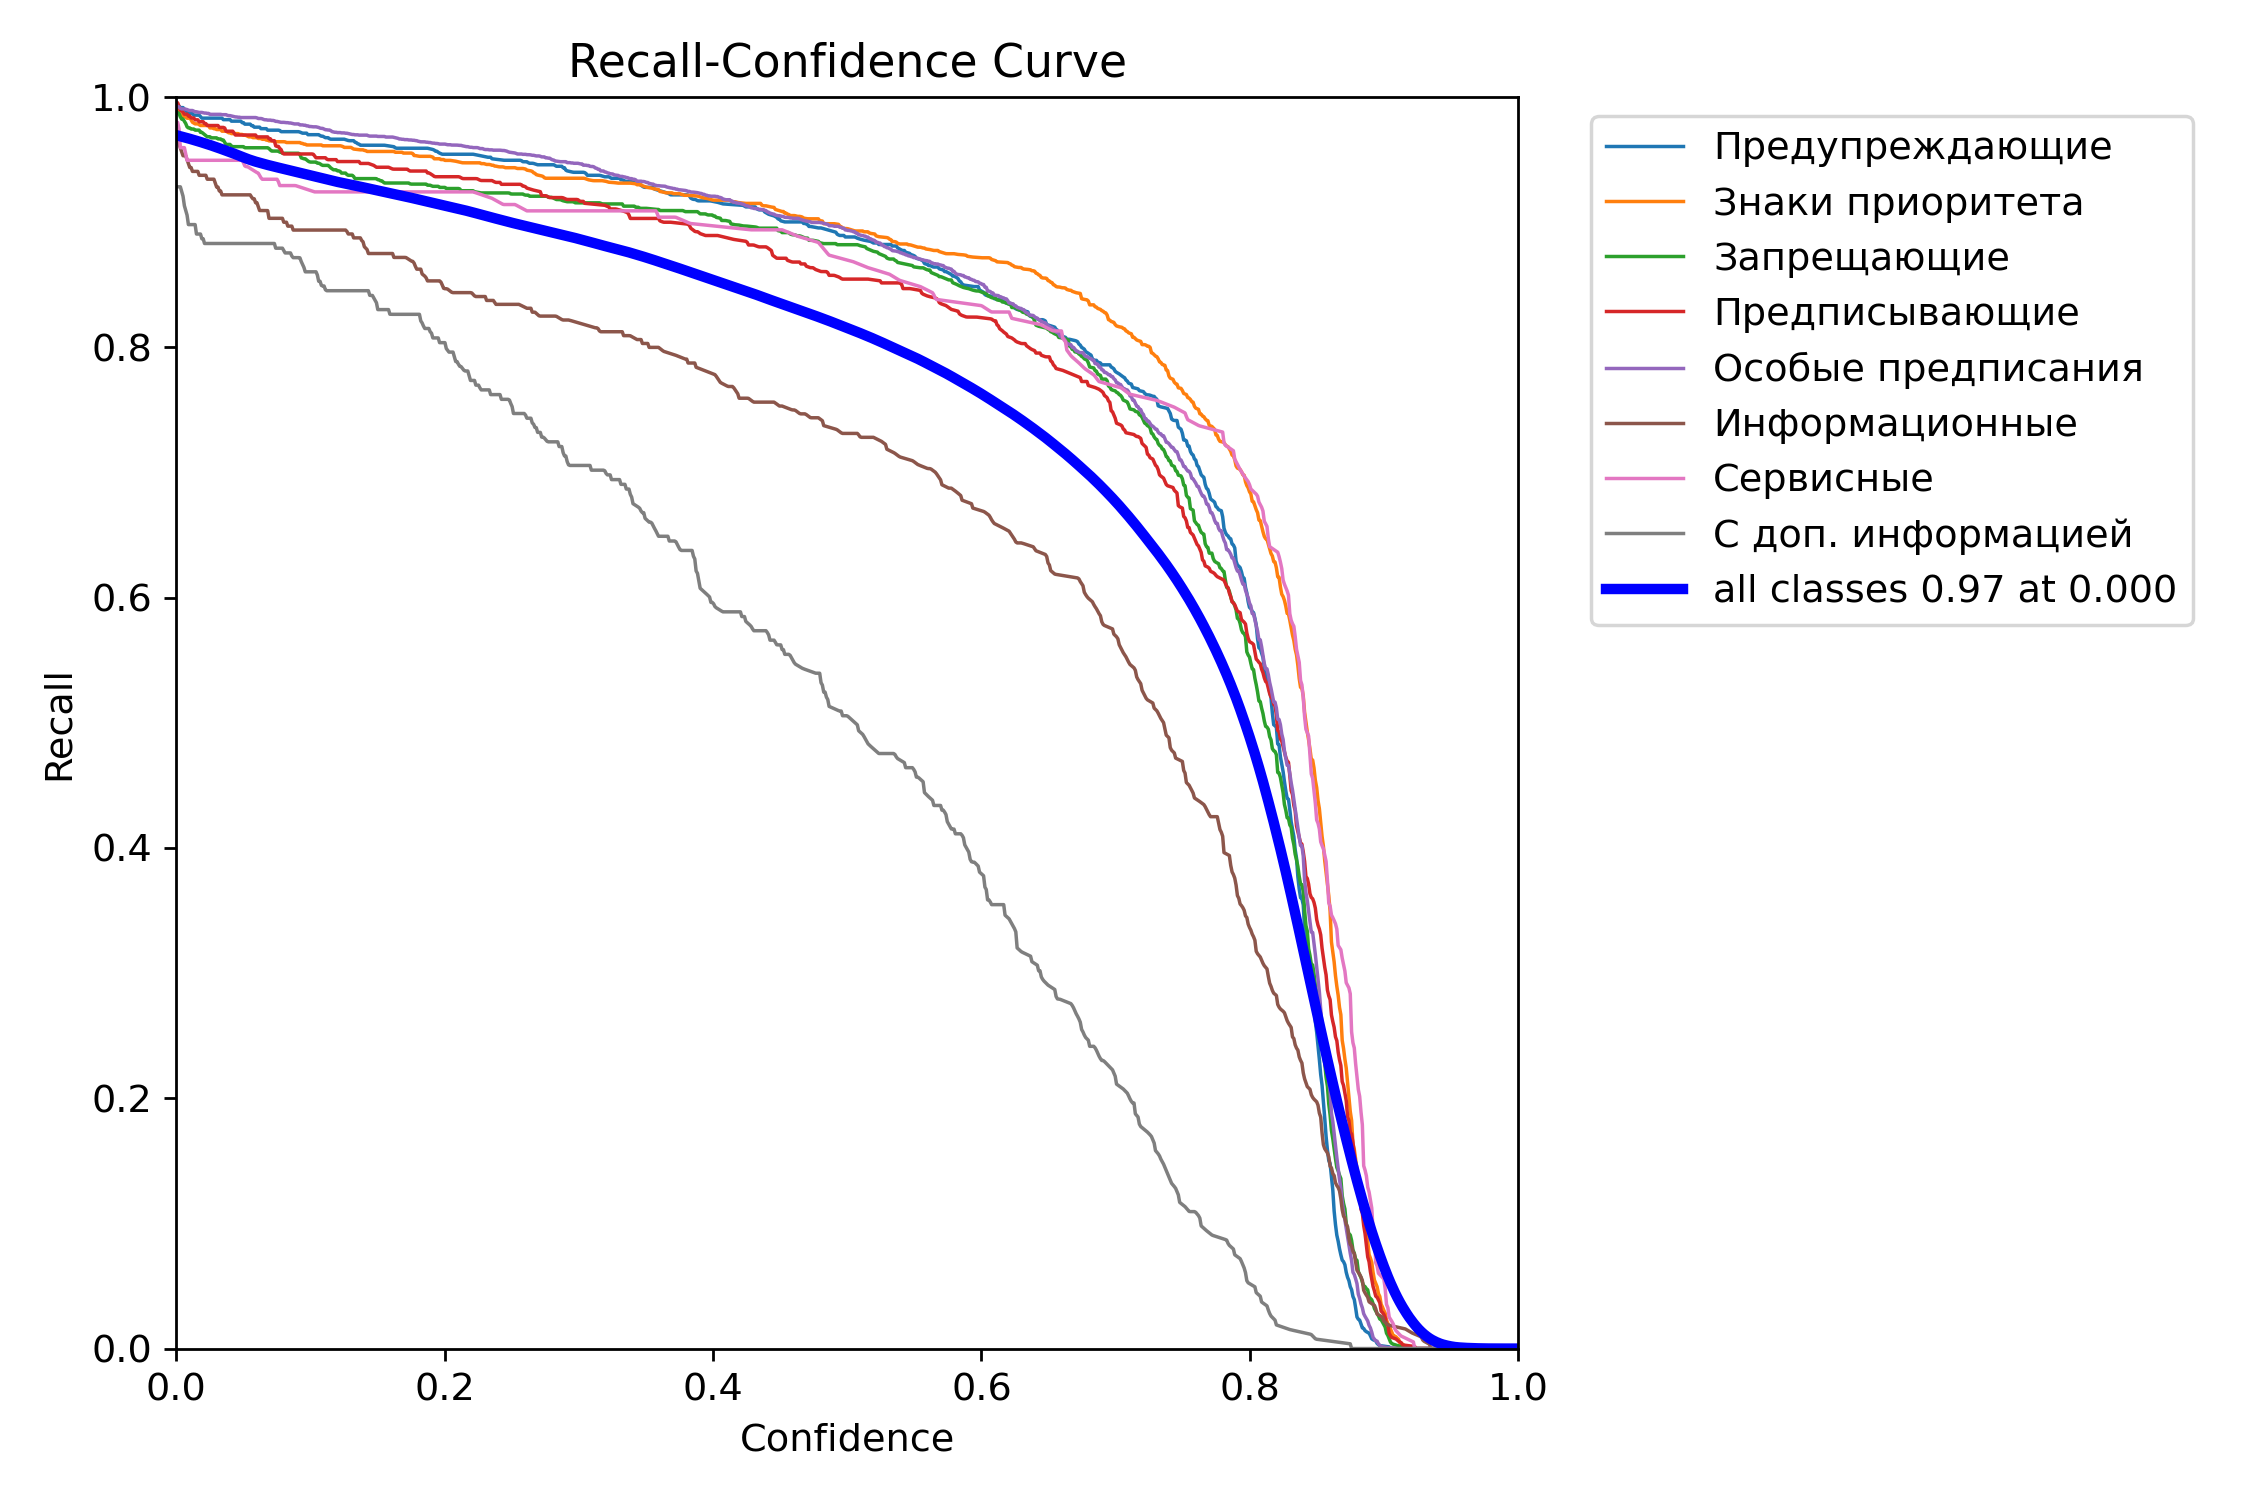

In [22]:
display.Image('RTSD_YOLO11s_without_aug/yolo11s_without_aug/R_curve.png', width=900, height=600)

**Примеры изображений из тренировочного датасета с нанесёнными аннотациями.**

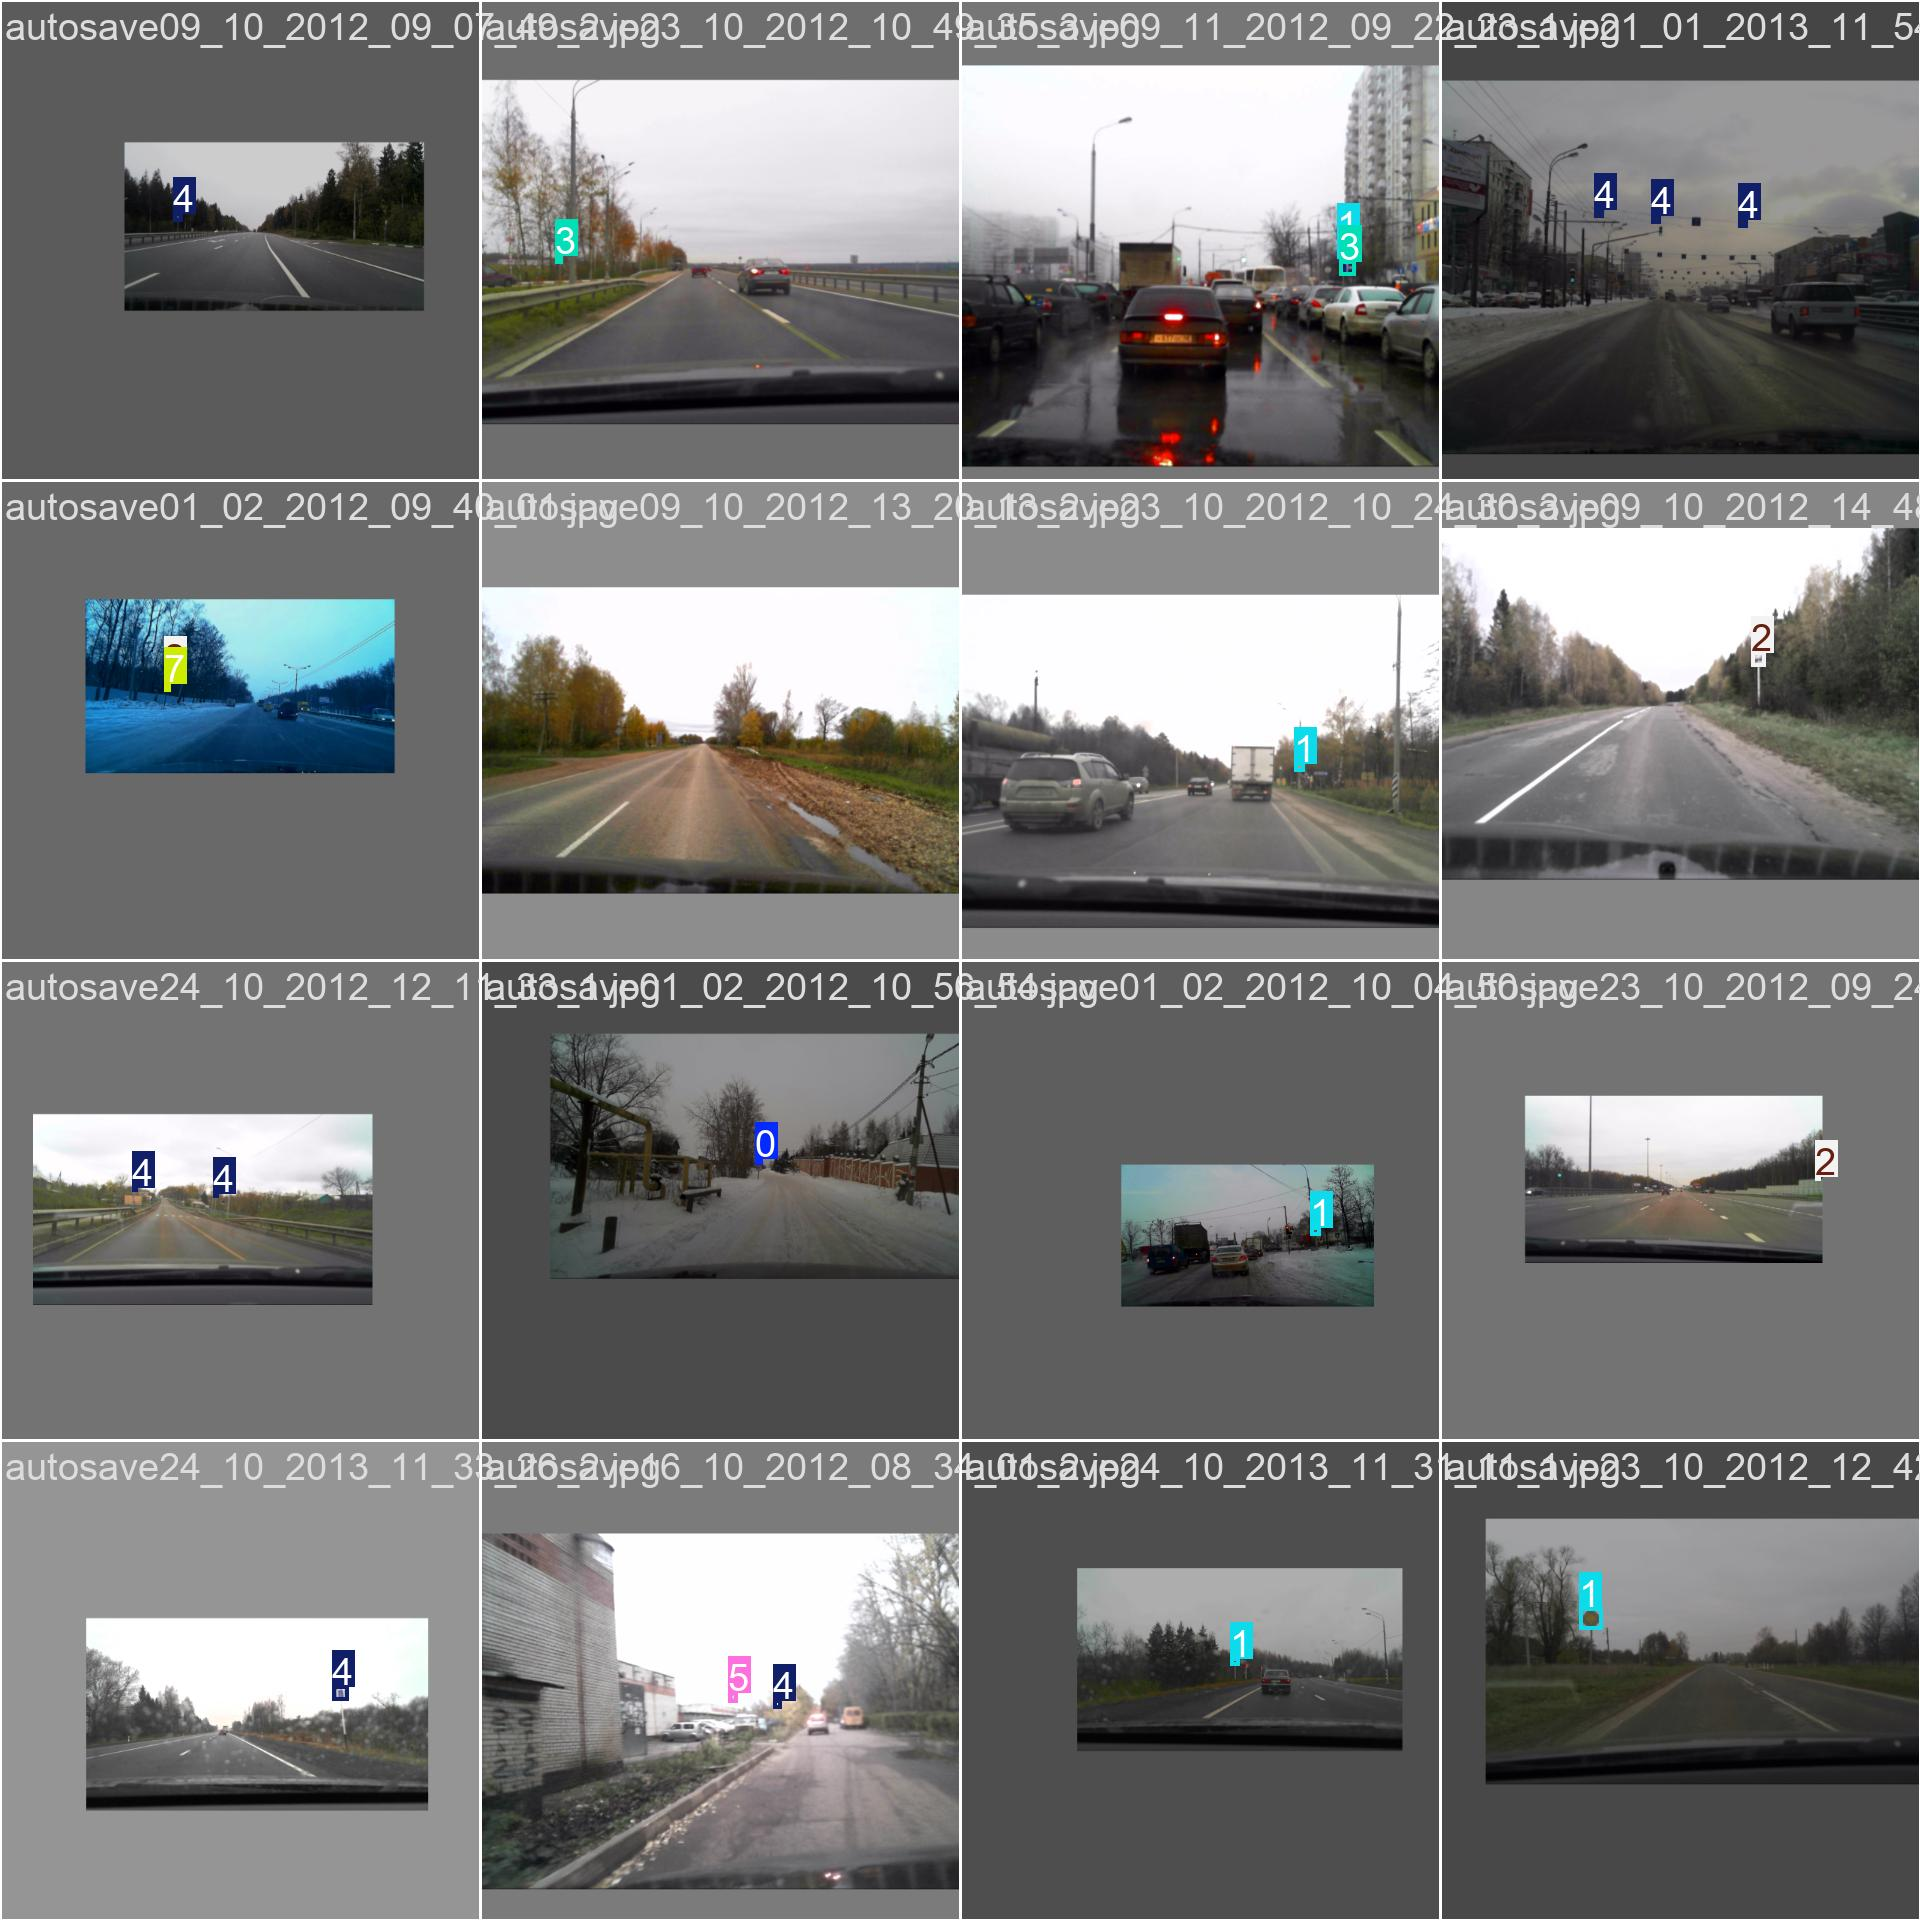

In [12]:
display.Image('RTSD_YOLO11s_without_aug/yolo11s_without_aug/train_batch1.jpg', width=1280, height=720)

**Примеры изображений из валидационного датасета с реальными и предсказанными аннотациями.**

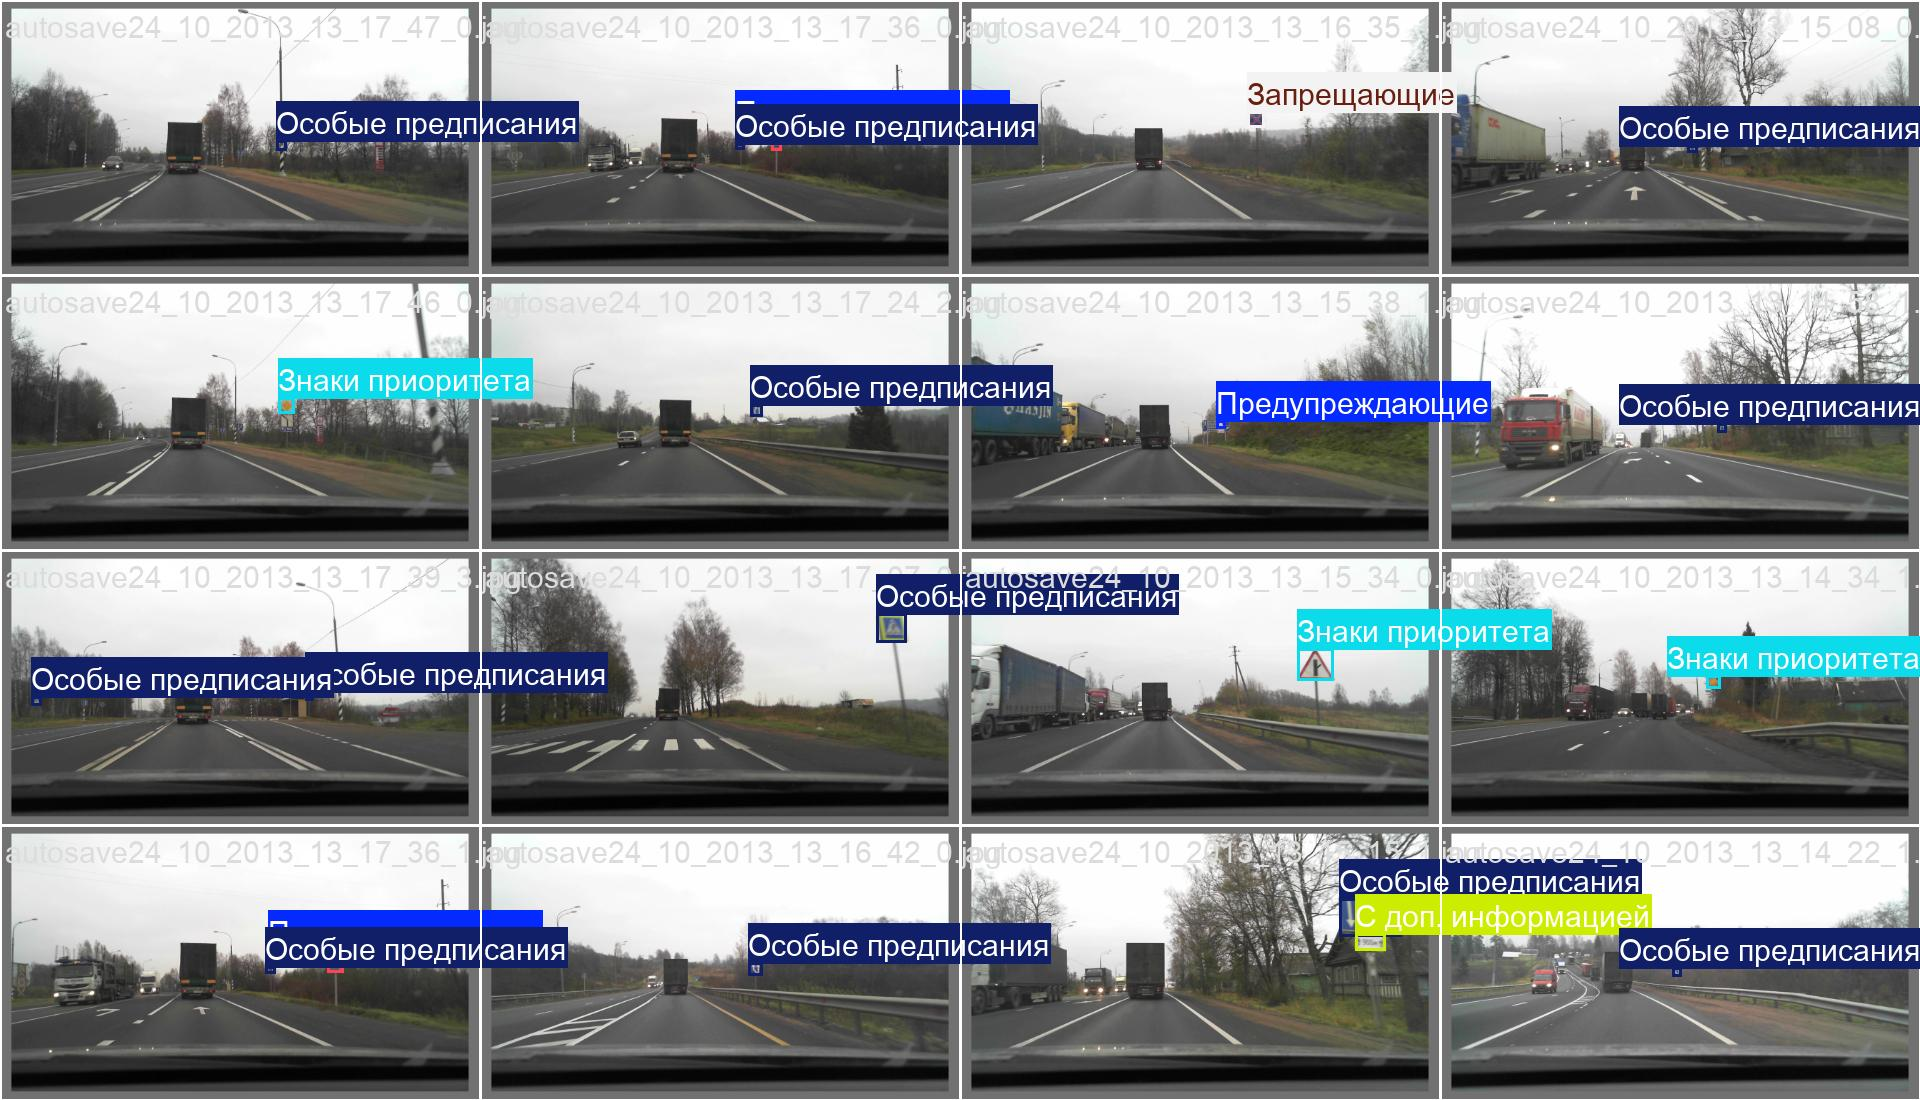

In [ ]:
display.Image('RTSD_YOLO11s_without_aug/yolo11s_without_aug/val_batch0_labels.jpg', width=1280, height=720) #True

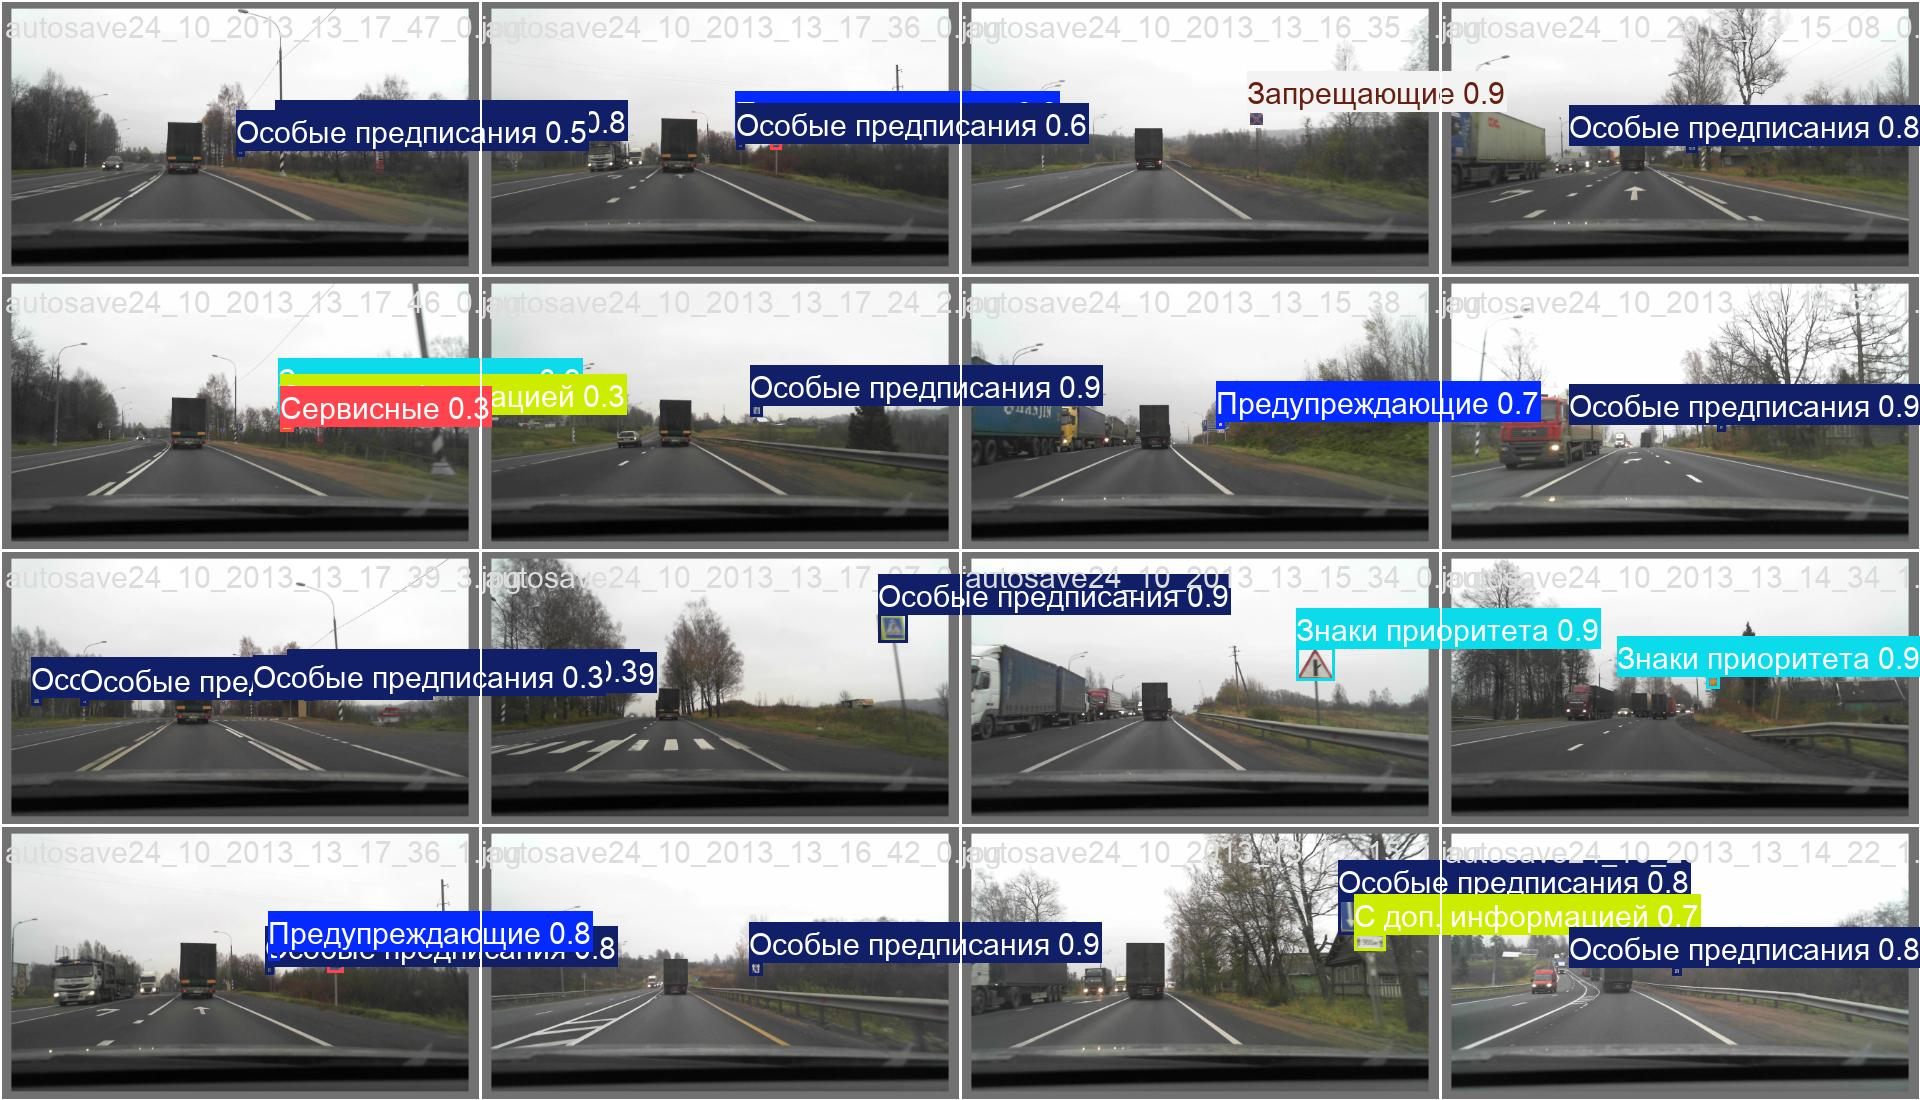

In [ ]:
display.Image('RTSD_YOLO11s_without_aug/yolo11s_without_aug/val_batch0_pred.jpg', width=1280, height=720) # Predicted

**CSV-таблица со всеми метриками по эпохам**

In [19]:
df_results_without_aug = pd.read_csv('RTSD_YOLO11s_without_aug/yolo11s_without_aug/results.csv')
df_results_without_aug

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,864.167,1.20885,1.04319,0.88420,0.76990,0.68939,0.76923,0.50995,1.09111,0.76757,0.85709,0.067010,0.000333,0.000333
1,2,1650.610,1.14480,0.79612,0.87046,0.78741,0.75730,0.81231,0.55485,1.02025,0.65225,0.84721,0.033944,0.000601,0.000601
2,3,2455.610,1.09786,0.72205,0.86250,0.83903,0.76457,0.83763,0.58753,0.97599,0.59297,0.84158,0.000812,0.000802,0.000802
3,4,3226.630,1.05099,0.66542,0.85289,0.84934,0.80695,0.87090,0.61591,0.94661,0.54968,0.83491,0.000703,0.000703,0.000703
4,5,3999.950,1.02347,0.62247,0.84765,0.86345,0.81172,0.88167,0.62724,0.92130,0.52993,0.83077,0.000604,0.000604,0.000604
5,6,4767.270,0.99590,0.58990,0.84266,0.86665,0.83838,0.89559,0.64590,0.89917,0.49859,0.82744,0.000505,0.000505,0.000505
6,7,5541.070,0.96911,0.56006,0.83939,0.86907,0.85381,0.90250,0.65803,0.88241,0.48315,0.82474,0.000406,0.000406,0.000406
7,8,6313.720,0.94868,0.53421,0.83595,0.87496,0.86146,0.91209,0.66859,0.87159,0.46914,0.82299,0.000307,0.000307,0.000307
8,9,7085.280,0.92434,0.50837,0.83350,0.88275,0.86203,0.91616,0.67453,0.85920,0.45530,0.82128,0.000208,0.000208,0.000208
9,10,7857.290,0.90747,0.48795,0.82976,0.88002,0.87159,0.91974,0.67890,0.85350,0.44919,0.82020,0.000109,0.000109,0.000109


| Столбец | Описание                                                   |
| ------- | ---------------------------------------------------------- |
| `epoch` | Номер текущей эпохи (итерации обучения).                   |
| `time`  | Время, затраченное на текущую эпоху.                       |
| `train/box_loss` | **Потери по координатам bbox** — показывает, насколько предсказанные координаты отличаются от правильных. Чем меньше, тем точнее модель "рисует" рамки. |
| `train/cls_loss` | **Классификационные потери** — как хорошо модель определяет правильный класс для объекта. Высокие значения → модель путается.                           |
| `train/dfl_loss` | **Distribution Focal Loss (DFL)** — используется для более точного определения положения боксов (разбиение координат на интервалы и регрессия).         |
| `metrics/precision(B)` | Precision (точность) — доля верных предсказаний среди всех предсказанных объектов.                                                 |
| `metrics/recall(B)`    | Recall (полнота) — доля правильно найденных объектов среди всех реальных.                                                          |
| `metrics/mAP50(B)`     | **mAP50 (mAP0.5)** — средняя точность (mean Average Precision) при IoU ≥ 0.5. Это ключевая метрика в задачах object detection.           |
| `metrics/mAP50-95(B)`  | **mAP50-95 (mAP0.5-0.95)** — средняя mAP по 10 IoU от 0.5 до 0.95 с шагом 0.05. Это более строгий и объективный показатель качества модели. |
| `val/box_loss`                                                       | bbox losses на валидации — как `train/box_loss`, только на отложенной выборке. |
| `val/cls_loss`                                                       | classification losses на валидации.                                            |
| `val/dfl_loss`                                                       | DFL на валидации.                                                              |
| `lr/pg0`, `lr/pg1`, `lr/pg2` | Learning rate для **разных групп параметров**:  *pg0* — обычно backbone (база модели), *pg1* — head (обнаружение объектов), *pg2* — bias-термы и т.д. Позволяет тонко управлять обучением разных частей модели. |




<Figure size 1200x600 with 0 Axes>

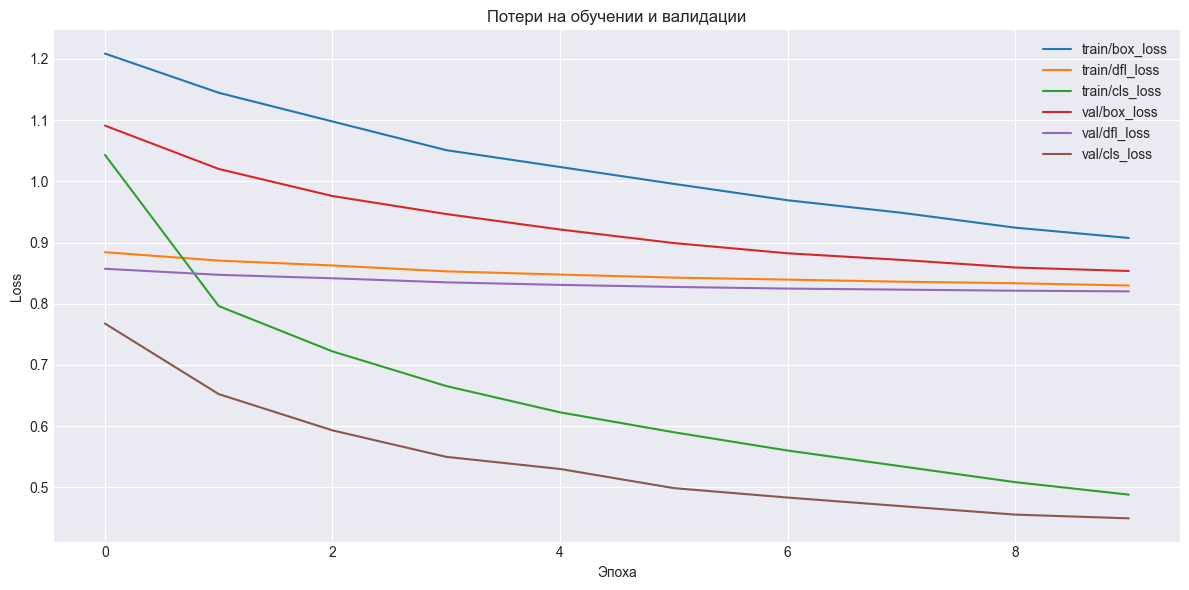

<Figure size 1200x600 with 0 Axes>

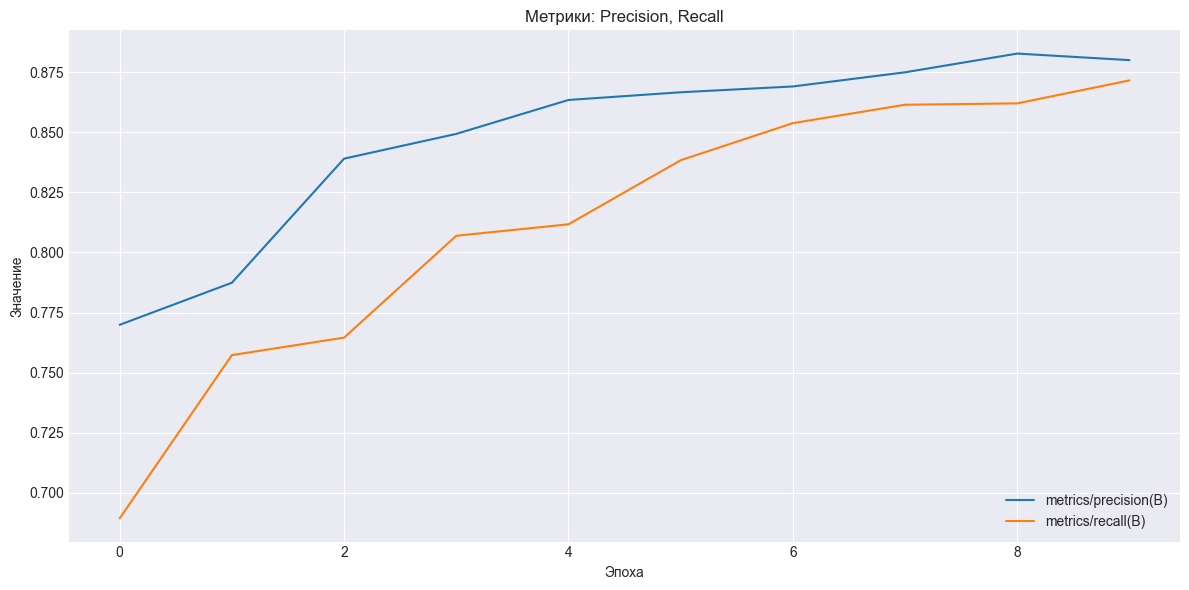

<Figure size 1200x600 with 0 Axes>

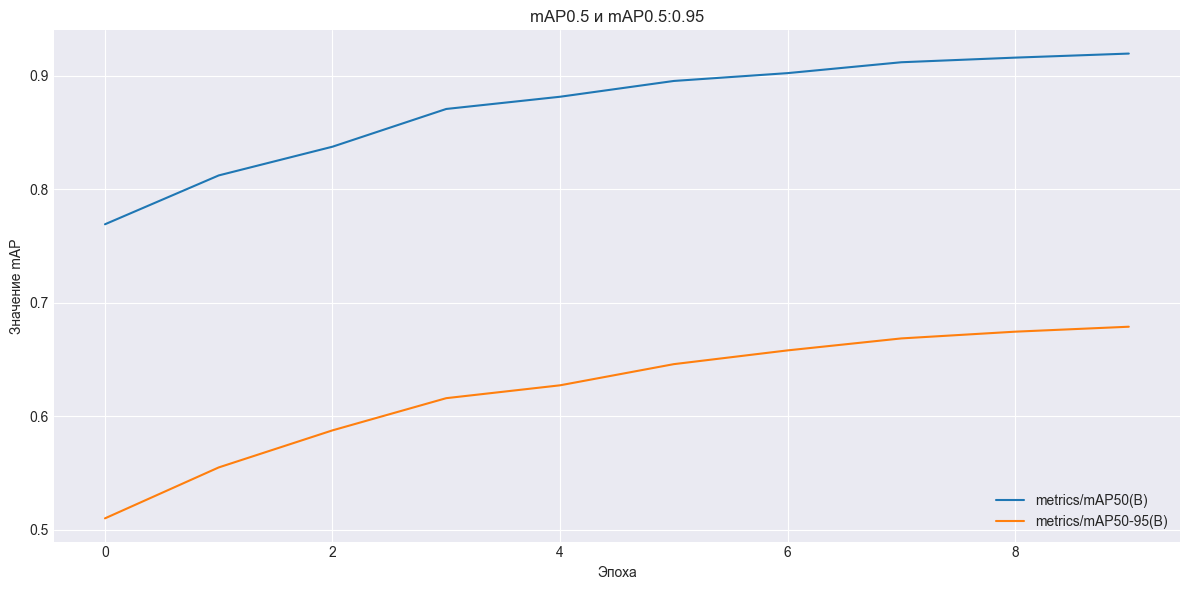

In [34]:
# Настройки стиля графиков
plt.style.use("seaborn-v0_8-darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)

# График потерь
plt.figure()
df_results_without_aug[["train/box_loss", "train/dfl_loss", "train/cls_loss",
                        "val/box_loss", "val/dfl_loss", "val/cls_loss"]].plot()
plt.title("Потери на обучении и валидации")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()

# График точности, полноты и F1
plt.figure()
df_results_without_aug[["metrics/precision(B)", "metrics/recall(B)"]].plot()
plt.title("Метрики: Precision, Recall")
plt.xlabel("Эпоха")
plt.ylabel("Значение")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# График mAP
plt.figure()
df_results_without_aug[["metrics/mAP50(B)", "metrics/mAP50-95(B)"]].plot()
plt.title("mAP0.5 и mAP0.5:0.95")
plt.xlabel("Эпоха")
plt.ylabel("Значение mAP")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

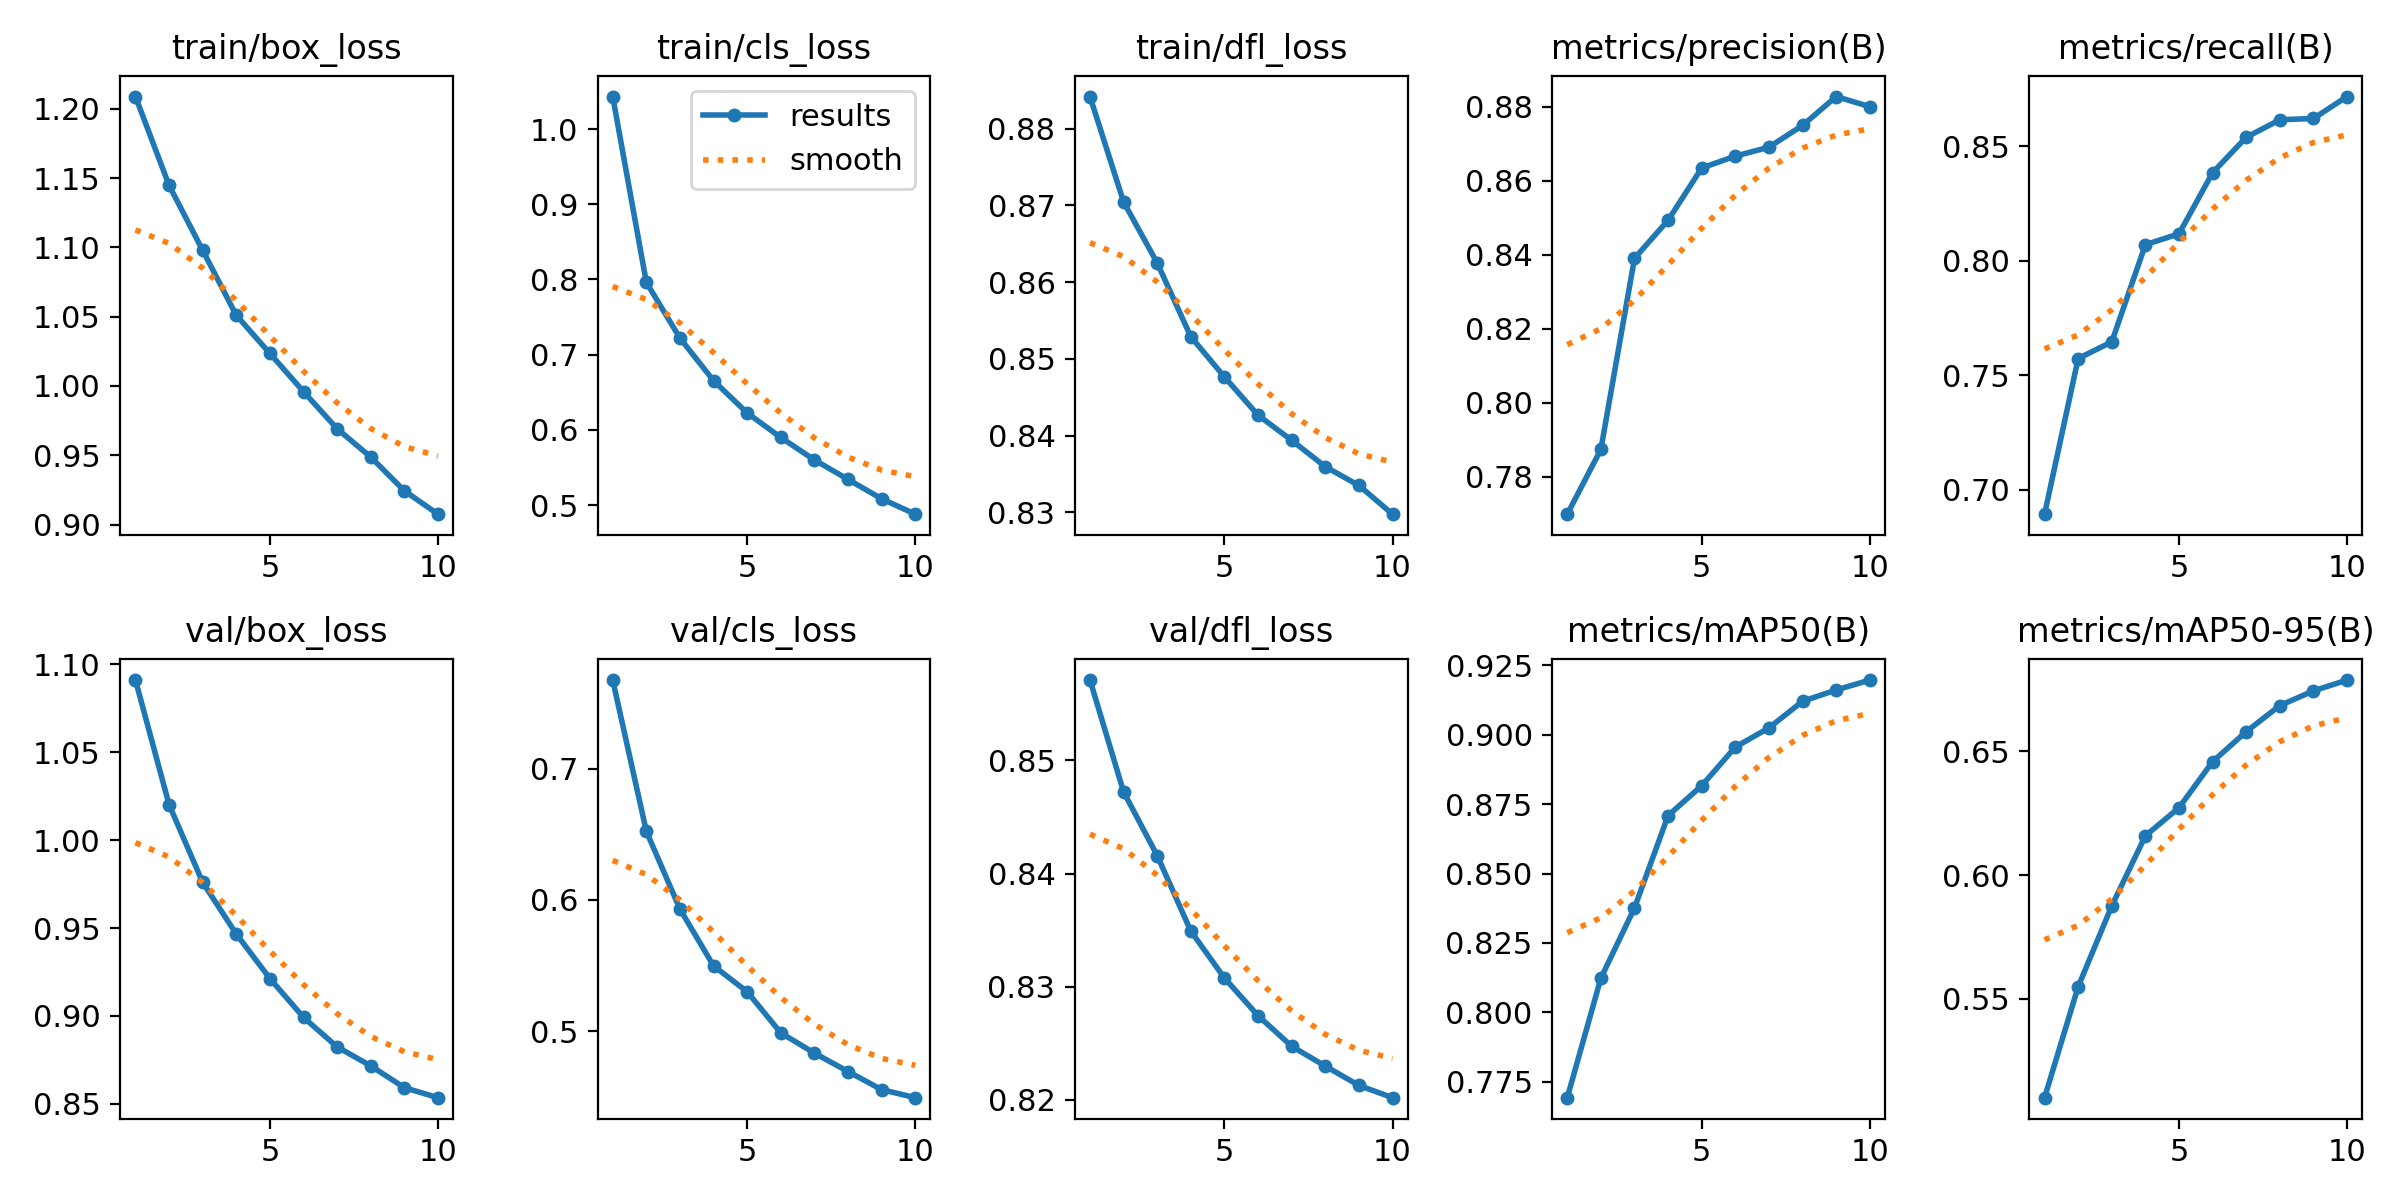

In [ ]:
# Те же графики, но по отдельности
display.Image('RTSD_YOLO11s_without_aug/yolo11s_without_aug/results.png', width=1200, height=600)

**Дополнительная функция для вывода всех полученных метрик**

In [ ]:
# Функция для вывода метрик модели

def evaluate_yolo_model(model_path, save_to_csv=False):
    """
    Полный анализ метрик YOLO модели
    
    Параметры:
        model_path: Путь к файлу модели (.pt)
        save_to_csv (bool): Сохранять ли метрики в CSV
        
    Возвращает:
        dict: Словарь со всеми метриками
    """
    # Загрузка модели
    model = YOLO(model_path)
    
    # Валидация
    metrics = model.val()
    
    # Сбор данных
    results = {
        'overall': {
            'mAP50': metrics.box.map50,
            'mAP50-95': metrics.box.map,
            'precision': metrics.box.mp,
            'recall': metrics.box.mr,
            'f1': 2*(metrics.box.mp*metrics.box.mr)/(metrics.box.mp+metrics.box.mr),
            'speed_ms': metrics.speed['inference']
        },
        'per_class': []
    }
    
    # Метрики по классам
    class_data = []
    for i in range(len(model.names)):
        class_result = metrics.box.class_result(i)
        class_metrics = {
            'class': model.names[i],
            'precision': class_result[0],
            'recall': class_result[1],
            'mAP50': class_result[2],
            'mAP50-95': class_result[3]
        }
        results['per_class'].append(class_metrics)
        class_data.append(class_metrics)
    
    # Конвертация в DataFrame
    df = pd.DataFrame(class_data)
    
    # Вывод результатов
    print("\n=== ОБЩИЕ МЕТРИКИ ===")
    print(f"mAP50: {results['overall']['mAP50']:.4f}")
    print(f"mAP50-95: {results['overall']['mAP50-95']:.4f}")
    print(f"Precision: {results['overall']['precision']:.4f}")
    print(f"Recall: {results['overall']['recall']:.4f}")
    print(f"F1-score: {results['overall']['f1']:.4f}")
    print(f"Speed: {results['overall']['speed_ms']:.2f} ms/img")
    
    print("\n=== МЕТРИКИ ПО КЛАССАМ ===")
    print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))
    
    # Сохранение в CSV
    if save_to_csv:
        df.to_csv(f"{model_path[:-3]}_metrics.csv", index=False)
        print(f"\nМетрики сохранены в {model_path[:-3]}_metrics.csv")
    
    return results

In [ ]:
if __name__ == "__main__":
    metrics_11s_without_aug = evaluate_yolo_model(
        model_path='RTSD_YOLO11s_without_aug/yolo11s_without_aug/weights/best.pt',
        save_to_csv=True
    )

Ultralytics 8.3.112  Python-3.12.8 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLO11s summary (fused): 100 layers, 9,415,896 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access  (ping: 0.10.0 ms, read: 1176.1536.7 MB/s, size: 166.6 KB)


val: Scanning C:\Innopolis\Zala_Project\rtsd_yolo_without_aug\val\labels.cache... 5000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5000/5000 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 313/313 [00:38<00:00,  8.12it/s]


                   all       5000       8866       0.88      0.872       0.92      0.682
               744        832      0.901      0.928      0.964      0.709
              1469       1542      0.935      0.929      0.971      0.745
                  1035       1136      0.907       0.91      0.954      0.703
                580        660      0.906      0.903      0.956       0.71
            2383       3913      0.885      0.932      0.962      0.714
                313        320      0.865      0.804      0.884       0.63
                     186        198      0.951      0.909      0.951      0.739
     .         245        265      0.687      0.664      0.715      0.503
Speed: 0.2ms preprocess, 3.4ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect\val

=== ОБЩИЕ МЕТРИКИ ===
mAP50: 0.9196
mAP50-95: 0.6816
Precision: 0.8797
Recall: 0.8724
F1-score: 0.8760
Speed: 3.40 ms/img

=== МЕТРИКИ ПО КЛАССАМ ===
+--------------------+-------------+-------

In [11]:
best_model_11s_without_aug

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(128, eps=0.001, momentum=0.03, affine=True, track_runnin